In [1]:
import pandas as pd
import numpy as np
df_train_filtered = pd.read_pickle('./data/df_train_filtered.pkl')


In [2]:
from sklearn.model_selection import train_test_split

X = df_train_filtered.drop('Hinta', axis=1)
y = df_train_filtered['Hinta']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=df_train_filtered['Kaupunginosa'], random_state=42)





In [3]:
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

def rmsle_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.log1p(y_true+1), np.log1p(y_pred+1)))

In [4]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)

r2 = r2_score(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
print(f"Mean squared error: {mse:.2f}\nMean absolute error: {mae:.2f}\nR²-arvo: {r2:.2f}\nRMSLE: {rmsle_score(y_test, predictions):.2f}")


Mean squared error: 9450.37
Mean absolute error: 68.02
R²-arvo: 0.63
RMSLE: 0.32


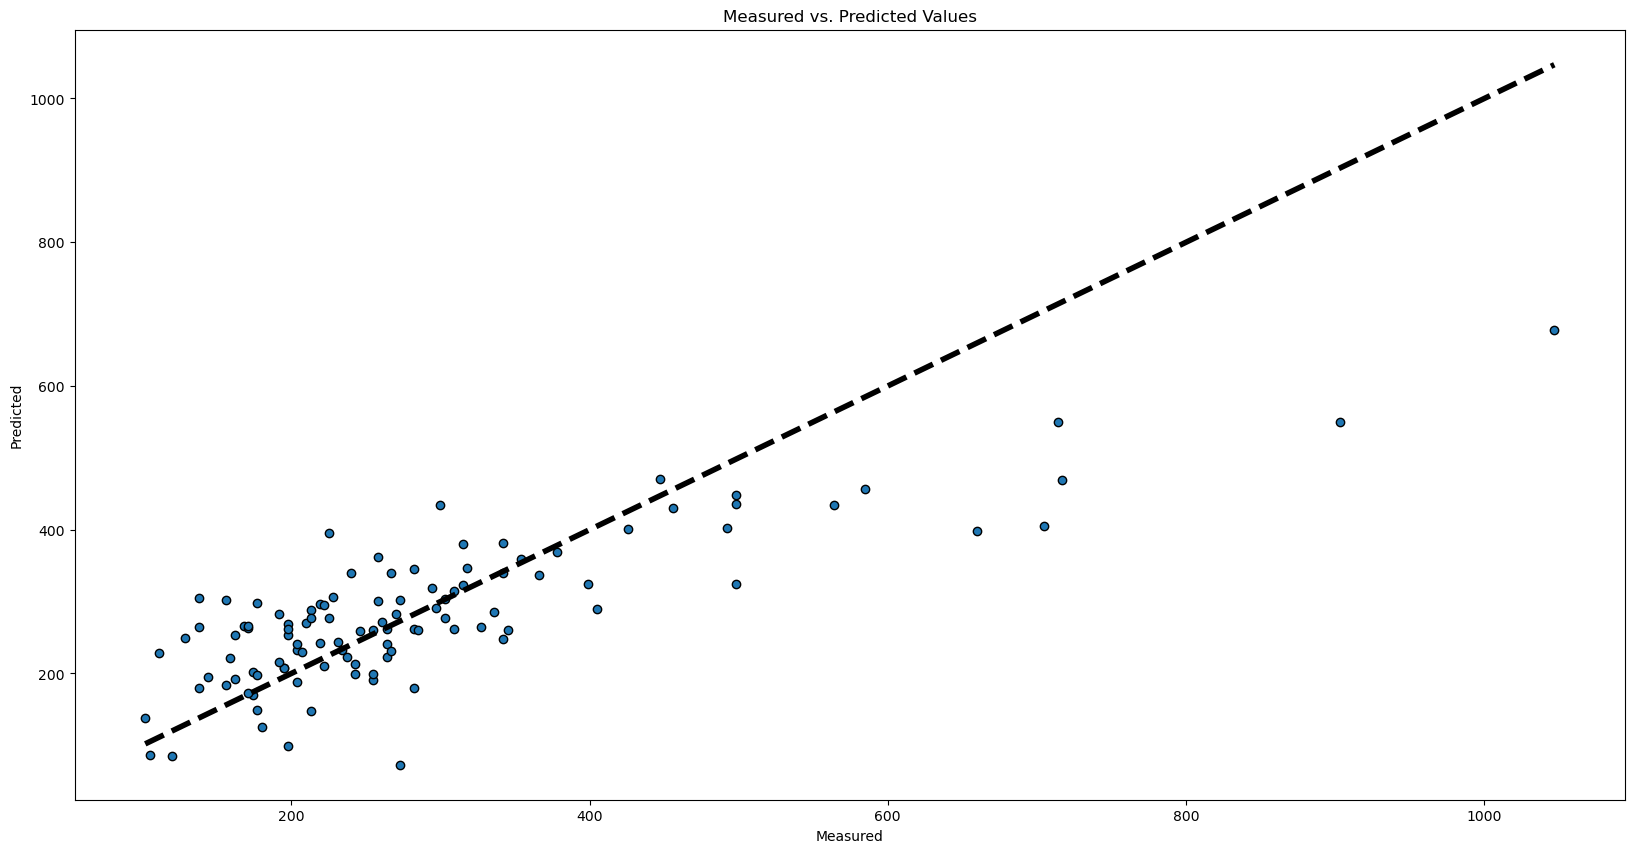

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Measured vs. Predicted Values')
plt.show()


Fitting 5 folds for each of 1 candidates, totalling 5 fits
With error: neg_mean_absolute_error
Ositus 0: 0.4127282800371684
Ositus 1: 0.45206943574905045
Ositus 2: 0.39057321266559913
Ositus 3: 0.4520691771837772
Ositus 4: 0.4129981534649943
Mean squared error: 26439.06
Mean absolute error: 100.83
RMSLE: 0.4459
Parhaan mallin R²-arvo: -0.0435
Time taken: 0:00:01.076823


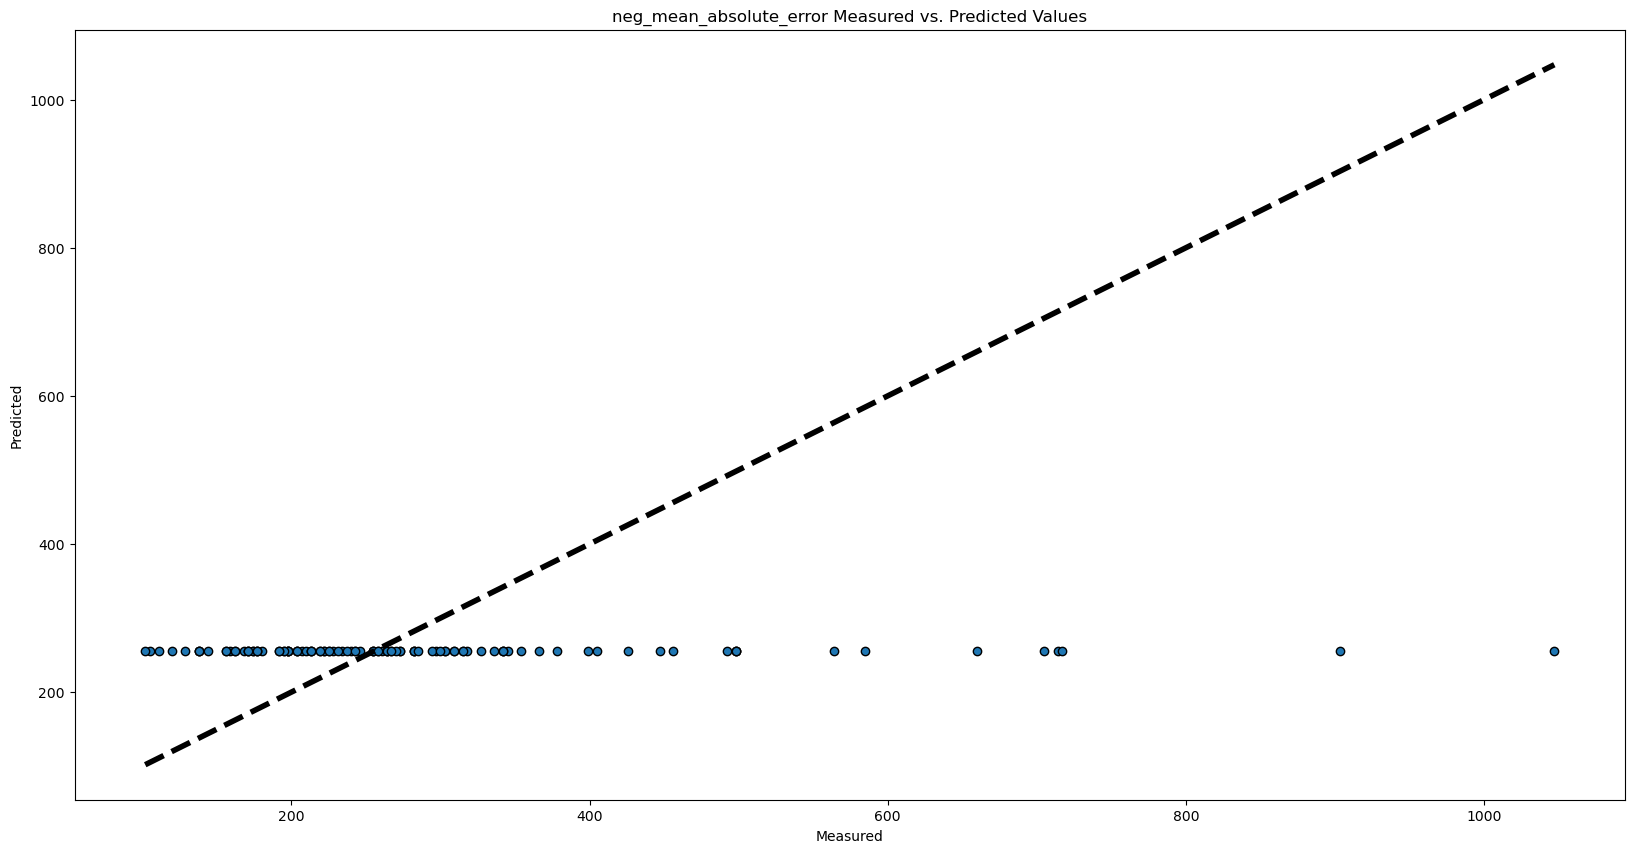

Fitting 5 folds for each of 1 candidates, totalling 5 fits
With error: neg_mean_squared_error
Ositus 0: 1.6902601143878535
Ositus 1: 1.7491973816395403
Ositus 2: 1.7866432230339722
Ositus 3: 1.772960407227291
Ositus 4: 1.7575028271532418
Mean squared error: 80049.07
Mean absolute error: 241.93
RMSLE: 1.7402
Parhaan mallin R²-arvo: -2.1593
Time taken: 0:00:00.859289


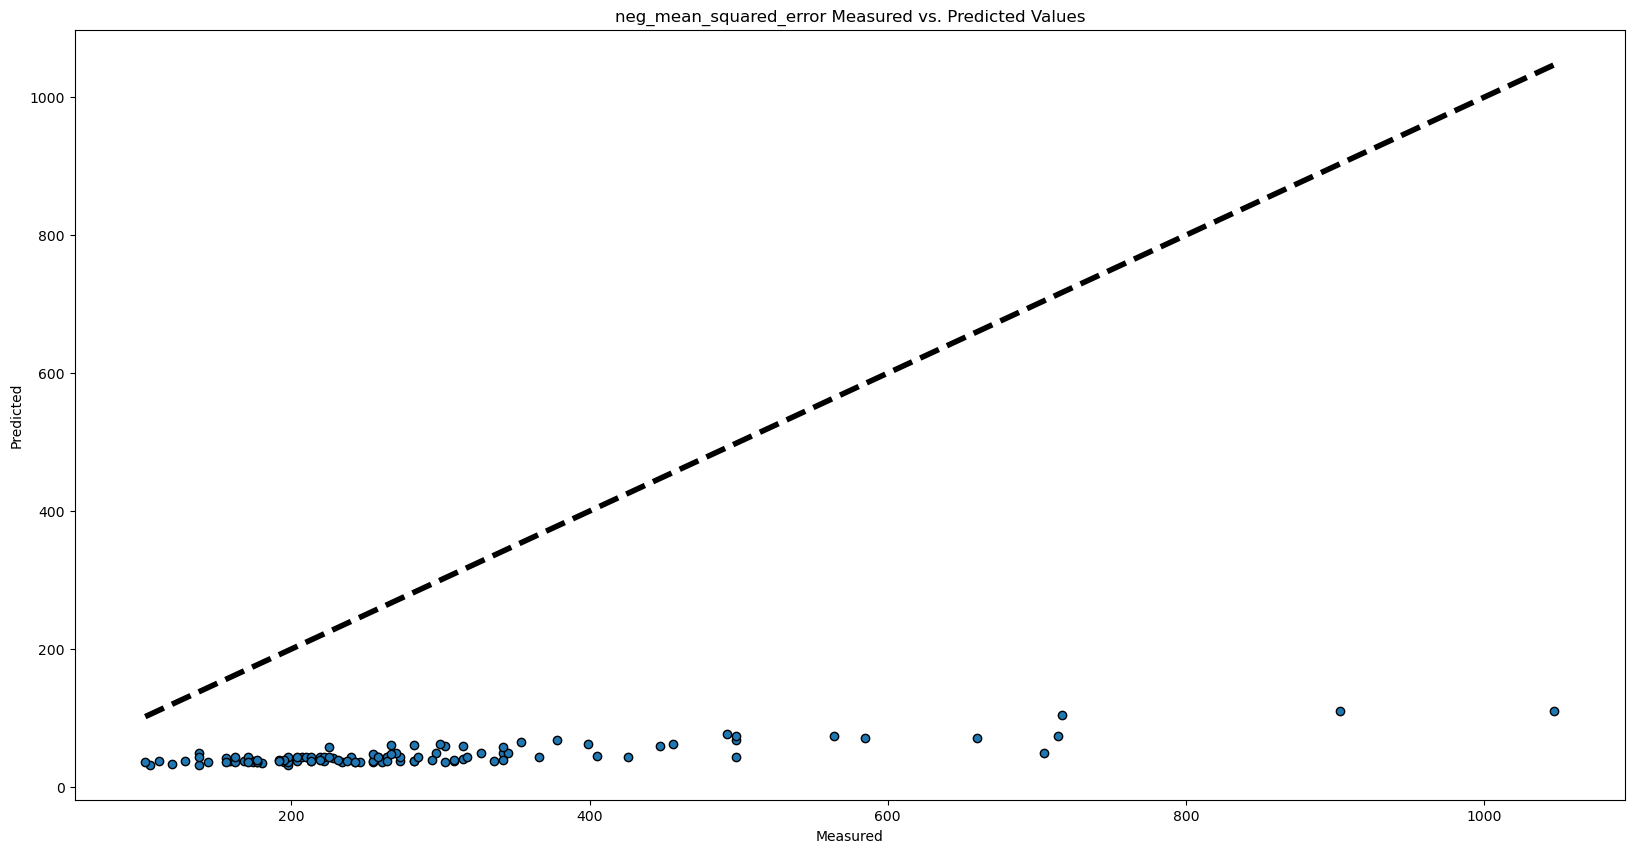

In [6]:
import numpy as np
import xgboost
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from datetime import timedelta
import matplotlib.pyplot as plt
import time 

from sklearn.metrics import make_scorer

def rmsle(y_true, y_pred):

    if np.any(y_pred <= 0):
        return 1e6

    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

 
virhe_mallit = [xgboost.XGBRegressor(objective='reg:absoluteerror'), xgboost.XGBRegressor(objective='reg:squarederror')]
virhe_nimi = ['neg_mean_absolute_error', 'neg_mean_squared_error']



for idx, malli in enumerate(virhe_mallit):
    time_start = time.time()
    param_space = {
        'n_estimators': np.arange(1, 500, 10),
        'max_depth': np.arange(3, 11),
        'learning_rate': [0.1, 0.01, 0.001],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'gamma': [0, 1, 5],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [1, 1.5, 2]
    }

    random_search = RandomizedSearchCV(
        estimator=malli,
        param_distributions=param_space,
        cv=5,
        n_jobs=-2,
        n_iter= 1,
        verbose=1,
        scoring=rmsle_scorer
    )


    random_search.fit(X_train, y_train)

    best_index = random_search.best_index_
    cv_results = random_search.cv_results_
    cv_splits = random_search.cv
    best_scores = [cv_results[f'split{i}_test_score'][best_index] for i in range(cv_splits)]


    print(f"With error: {virhe_nimi[idx]}")
    for i, score in enumerate(best_scores):
        print(f"Ositus {i}: {-score}")

    best_model = random_search.best_estimator_
    predictions = best_model.predict(X_test)

    time_end = time.time()

    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmsle = rmsle_score(y_test, predictions)
    r2 = r2_score(y_test, predictions)    
    print(f"Mean squared error: {mse:.2f}\nMean absolute error: {mae:.2f}\nRMSLE: {rmsle:.4f}\nParhaan mallin R²-arvo: {r2:.4f}")
    print(f"Time taken: {str(timedelta(seconds=(time_end - time_start)))}")

    plt.figure(figsize=(20, 10))
    plt.scatter(y_test, predictions, edgecolors=(0, 0, 0))
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.title(f'{virhe_nimi[idx]} Measured vs. Predicted Values')
    plt.show()




In [7]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler 

# Skaalataan numeeriset muuttujat
robust_scaler = RobustScaler()
std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
df_train_NN = df_train_filtered.copy()
df_train_NN[['Pituusaste', 'Leveysaste']] = minmax_scaler.fit_transform(df_train_NN[['Pituusaste', 'Leveysaste']])
df_train_NN['Rv'] = minmax_scaler.fit_transform(df_train_NN[['Rv']])
df_train_NN['m2'] = minmax_scaler.fit_transform(df_train_NN[['m2']])

# One hot koodataan kategoriset muuttujat
df_hot = pd.get_dummies(df_train_NN['Kaupunginosa'], prefix='Kaupunginosa').astype('int')
df_train_NN = pd.concat([df_train_NN, df_hot], axis=1)

df_hot = pd.get_dummies(df_train_NN['kerros'], prefix='kerros').astype('int')
df_train_NN = pd.concat([df_train_NN, df_hot], axis=1)

df_hot = pd.get_dummies(df_train_NN['max_kerros'], prefix='max_kerros').astype('int')
df_train_NN = pd.concat([df_train_NN, df_hot], axis=1)

df_hot = pd.get_dummies(df_train_NN['Kunto'], prefix='Kunto').astype('int')
df_train_NN = pd.concat([df_train_NN, df_hot], axis=1)

df_hot = pd.get_dummies(df_train_NN['Hissi'], prefix='Hissi').astype('int')
df_train_NN = pd.concat([df_train_NN, df_hot], axis=1)

df_hot = pd.get_dummies(df_train_NN['Asunnon tyyppi'], prefix='Asunnon tyyppi').astype('int')
df_train_NN = pd.concat([df_train_NN, df_hot], axis=1)

df_hot = pd.get_dummies(df_train_NN["Talot."], prefix='Talot.').astype('int')
df_train_NN = pd.concat([df_train_NN, df_hot], axis=1)


df_train_NN.drop(['Kaupunginosa', 'kerros', 'max_kerros', 'Kunto', 'Hissi', 'Asunnon tyyppi', "Talot."], axis=1, inplace=True)




In [8]:
# Muodostetaan X ja y sekä jaetaan data harjoitus- ja testijoukkoihin

X = df_train_NN.drop('Hinta', axis=1)
y = df_train_NN['Hinta']

X = X.to_numpy()
y = y.to_numpy().astype('float32')

X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(X, y, test_size=0.1, random_state=42, stratify=df_train_filtered['Kaupunginosa'])

In [9]:
import optuna
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras import regularizers, layers, optimizers, initializers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
import time 
from optuna.integration import TFKerasPruningCallback
import os 
import pickle 


# Haun nimi
study_name = 'optuna_test2fold_rmsle'
# Montako osittelua käytettiin
folds = 2
# Montako epochia kullekin osittelulle
epochs_search = 30
# Montako satunnaista hakua kieroksella
num_random = 10
# Montako TPE hakua kieroksella
num_tpe = 10

def rmsle_loss(y_true, y_pred):
    # Asetetaan suuri rangaistusarvo, jos y_pred sisältää arvon nolla tai alle
    penalty = tf.constant(1e5, dtype=tf.float32)
    
    # Maski, joka on tosi, kun y_pred on > 0
    valid_mask = tf.math.greater(y_pred, 0.0)
    
    # Käytä maskia valitsemaan joko oikea RMSLE laskenta tai suuri rangaistus
    safe_y_pred = tf.where(valid_mask, y_pred, penalty)
    
    # Laske RMSLE vain, jos y_pred on suurempi kuin 0, muuten palauta rangaistus
    rmsle = tf.sqrt(tf.reduce_mean(tf.square(tf.math.log1p(safe_y_pred) - tf.math.log1p(y_true))))
    
    # Palauta suuri rangaistus, jos y_pred sisälsi nollan tai negatiivisen arvon
    return tf.where(tf.reduce_any(~valid_mask), penalty, rmsle)


def create_model(trial):
    # Mallin arkkitehtuurin määrittely
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(X_train_NN.shape[1],)))
    
    n_layers = trial.suggest_int('n_layers', 1, 3)
    
    for i in range(n_layers):
        num_hidden = trial.suggest_int(f'n_units_{i}', 4, 512)
        dropout_rate = trial.suggest_float(f'dropout_{i}', 0.0, 0.5)
        kernel_regularizer=regularizers.l1_l2(
            l1= trial.suggest_float(f'l1_reg_{i}', 1e-6, 1, log=True),
            l2= trial.suggest_float(f'l2_reg_{i}', 1e-6, 1, log=True)
        )
        activation = trial.suggest_categorical(f'activation_{i}', ['relu', 'tanh', 'selu', 'linear', 'sigmoid', 'elu'])
        model.add(keras.layers.Dense(num_hidden, activation=activation, kernel_regularizer=kernel_regularizer))    
        model.add(keras.layers.Dropout(rate=dropout_rate))
    
    num_last = trial.suggest_int('n_units_last', 1, 64)
    dropout_last = trial.suggest_float('dropout_last', 0.0, 0.5)
    activation_last = trial.suggest_categorical('activation_last', ['relu', 'tanh', 'selu', 'linear', 'sigmoid', 'elu'])
    kernel_regularizer_last = regularizers.l1_l2( 
        l1= trial.suggest_float('l1_reg_last', 1e-6, 1, log=True),
        l2= trial.suggest_float('l2_reg_last', 1e-6, 1, log=True)
    )
    model.add(keras.layers.Dense(num_last, activation=activation_last, kernel_regularizer=kernel_regularizer_last))        
    model.add(keras.layers.Dropout(rate=dropout_last))
    model.add(keras.layers.Dense(1, activation='linear')) 
    
    # Optimisaattorin ja oppimisnopeuden valinta
    optimizer_options = ['adam', 'rmsprop', 'Nadam', 'adamax', 'Adagrad', 'Adadelta']
    optimizer_selected = trial.suggest_categorical('optimizer', optimizer_options)
    learning_rate = trial.suggest_float('lr', 1e-4, 1.0, log=True)
    
    if optimizer_selected == 'adam':
        optimizer = optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_selected == 'rmsprop':
        optimizer = optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_selected == 'Nadam':
        optimizer = optimizers.Nadam(learning_rate=learning_rate)
    elif optimizer_selected == 'Adagrad':
        optimizer = optimizers.Adagrad(learning_rate=learning_rate)
    elif optimizer_selected == 'Adadelta':
        optimizer = optimizers.Adadelta(learning_rate=learning_rate)
    else:
        optimizer = optimizers.Adamax(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss=rmsle_loss, metrics=['mse', 'mae'])
    
    return model

def objective(trial):

    model = create_model(trial)
    batch_size = trial.suggest_int('batch_size', 16, 128)    
    callbacks = [TFKerasPruningCallback(trial, 'val_loss'),
                 ReduceLROnPlateau('val_loss', patience=10, factor=0.6), 
                 TerminateOnNaN()]

    history = model.fit(X_train_b, y_train_b, epochs=epochs_search, validation_data=(X_val_b, y_val_b) ,batch_size=batch_size, verbose=0, callbacks=callbacks)
    val_loss = np.min(history.history['val_loss'])
    
    return val_loss




total_time_start = time.time()  
search_time_start = time.time() 
num_completed_trials = 0
search_rounds = 0
time_taken = 0
while time_taken < 3600:
        
    fold = 0
    kf = KFold(n_splits=folds)
    
    time_fold_start = time.time()    
    for train_index, val_index in kf.split(X_train_NN):

        print('-------------------')
        print(f"Starting fold {fold} search...")
        X_train_b, X_val_b = X_train_NN[train_index], X_train_NN[val_index]    
        y_train_b, y_val_b = y_train_NN[train_index], y_train_NN[val_index]

        study_filename = f'./NN_search/{study_name}_{fold}.pkl'
        if os.path.exists(study_filename):
            with open(study_filename, 'rb') as f:
                study = pickle.load(f)
        else:
            study = optuna.create_study(direction='minimize',
                                        pruner=optuna.pruners.HyperbandPruner(min_resource=2))

        fold_time = time.time()    

        fold_random = time.time()
        study.sampler = optuna.samplers.RandomSampler()
        print(f'Random search for fold {fold}...')
        study.optimize(objective, n_trials=num_random)
        print(f'Time taken for random search: {str(timedelta(seconds=(time.time() - fold_random)))}')

        fold_tpe = time.time()  
        study.sampler = optuna.samplers.TPESampler()
        print(f'TPE search for fold {fold}...')
        study.optimize(objective, n_trials=num_tpe)
        print(f'Time taken for TPE search: {str(timedelta(seconds=(time.time() - fold_tpe)))}')

        num_completed_trials += num_random + num_tpe
        
        with open(study_filename, 'wb') as f:
            pickle.dump(study, f)

        print('-------------------')
        print(f'Finished fold {fold} search.')
        print(f"Time taken for this fold: {str(timedelta(seconds=(time.time() - fold_time)))}")                
        print(f'Fold {fold} best value so far: {study.best_value}')
        

        fold += 1
    search_rounds += 1
    
    time_taken = time.time() - search_time_start
    
    print(f'\n# Completed search round: {search_rounds} #')
    print(f'Time taken for all folds this round: {str(timedelta(seconds=(time.time() - time_fold_start)))}')
    print(f'Total time taken for search: {str(timedelta(seconds=(time.time() - search_time_start)))}')
    print(f'Made trials this far: {num_completed_trials}')
    print(f"Current mean time for one trial: {str(timedelta(seconds=(time.time() - search_time_start) / num_completed_trials))}\n")
    

print('='*20)    
print(f'Finished search.')    
print(f'Total time taken for all folds: {str(timedelta(seconds=(time.time() - search_time_start)))}')
print(f'Made {num_completed_trials} trials in total.')
print(f"Mean time for one trial: {str(timedelta(seconds=(time.time() - search_time_start) / num_completed_trials))}")
print('='*20)


/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-23 15:12:58.209042: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-23 15:12:58.768336: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[I 2024-03-23 15:12:59,239] A new study created in memory with name: no-name-e804fd19-7a3d-4954-8ae8-f68ba9272340


Starting fold 0 search...
Random search for fold 0...


2024-03-23 15:12:59.461038: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-23 15:12:59.483265: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-23 15:12:59.483334: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-23 15:12:59.487066: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-23 15:12:59.487137: I tensorflow/compile

Time taken for random search: 0:00:33.236351
TPE search for fold 0...


[I 2024-03-23 15:13:35,006] Trial 10 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:13:36,464] Trial 11 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:13:40,132] Trial 12 finished with value: 100000.0078125 and parameters: {'n_layers': 1, 'n_units_0': 24, 'dropout_0': 0.011711071131084771, 'l1_reg_0': 5.7363272717742384e-05, 'l2_reg_0': 0.004954960229802692, 'activation_0': 'sigmoid', 'n_units_last': 45, 'dropout_last': 0.3392443944792855, 'activation_last': 'sigmoid', 'l1_reg_last': 0.00980327295528748, 'l2_reg_last': 1.899455571078097e-06, 'optimizer': 'rmsprop', 'lr': 0.0018952804198819468, 'batch_size': 93}. Best is trial 3 with value: 5.246737480163574.
[I 2024-03-23 15:13:44,874] Trial 13 finished with value: 8.124638557434082 and parameters: {'n_layers': 1, 'n_units_0': 193, 'dropout_0': 0.09391380447040898, 'l1_reg_0': 1.0496409036120886e-06, 'l2_reg_0': 0.14989983656776154, 'activation_0': 'relu', 'n_units_last': 6, 'dropout_last': 0.18612683024300086, 'activati

Time taken for TPE search: 0:00:27.042970
-------------------
Finished fold 0 search.
Time taken for this fold: 0:01:00.281043
Time taken this far: 0:01:00.282927
Fold 0 best value so far: 5.048872947692871
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-23 15:14:06,637] Trial 0 finished with value: 100004.171875 and parameters: {'n_layers': 1, 'n_units_0': 198, 'dropout_0': 0.2003785203454132, 'l1_reg_0': 0.0005913765600066894, 'l2_reg_0': 7.101368454684208e-05, 'activation_0': 'selu', 'n_units_last': 42, 'dropout_last': 0.3095271216443628, 'activation_last': 'linear', 'l1_reg_last': 0.01963253920689474, 'l2_reg_last': 0.0001838198176901159, 'optimizer': 'Nadam', 'lr': 0.09714260644985585, 'batch_size': 46}. Best is trial 0 with value: 100004.171875.
[I 2024-03-23 15:14:11,354] Trial 1 finished with value: 13.634175300598145 and parameters: {'n_layers': 1, 'n_units_0': 336, 'dropout_0': 0.1318678953607163, 'l1_reg_0': 0.010335712274668488, 'l2_reg_0': 0.03165633865482029, 'activation_0': 'sigmoid', 'n_units_last': 31, 'dropout_last': 0.19972726871440477, 'activation_last': 'linear', 'l1_reg_last': 0.02583972071239444, 'l2_reg_last': 6.933629767837074e-05, 'optimizer': 'adamax', 'lr': 0.7217933070909577, 'batch_size': 52}. B

Time taken for random search: 0:00:42.082432
TPE search for fold 1...


[I 2024-03-23 15:14:44,781] Trial 10 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:14:45,796] Trial 11 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:14:47,773] Trial 12 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:14:50,289] Trial 13 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:14:51,406] Trial 14 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:14:53,419] Trial 15 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:14:54,656] Trial 16 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:14:57,905] Trial 17 finished with value: 59.956295013427734 and parameters: {'n_layers': 3, 'n_units_0': 214, 'dropout_0': 0.17269351713122683, 'l1_reg_0': 1.0453316626043642e-06, 'l2_reg_0': 1.1734880723865488e-06, 'activation_0': 'selu', 'n_units_1': 345, 'dropout_1': 0.499198752175012, 'l1_reg_1': 0.02160668305223969, 'l2_reg_1': 6.451263243643788e-05, 'activation_1': 'sigmoid', 'n_units_2': 363, 'dropout_2': 0.1531663688228337, 'l1_reg_2': 0.00017158058502

Time taken for TPE search: 0:00:19.989075
-------------------
Finished fold 1 search.
Time taken for this fold: 0:01:02.073371
Time taken this far: 0:02:02.357801
Fold 1 best value so far: 2.0936460494995117
# Completed search round: 1 #
Time taken for all folds this round: 0:02:02.357826
Total time taken for search: 0:02:02.358113
Made trials this far: 40
Current mean time for one trial: 0:00:03.058953
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-23 15:15:02,867] Trial 20 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:15:04,001] Trial 21 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:15:05,185] Trial 22 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:15:06,712] Trial 23 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:15:07,521] Trial 24 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:15:08,894] Trial 25 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:15:12,532] Trial 26 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:15:13,597] Trial 27 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:15:15,193] Trial 28 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:15:17,161] Trial 29 pruned. Trial was pruned at epoch 18.


Time taken for random search: 0:00:15.563087
TPE search for fold 0...


[I 2024-03-23 15:15:21,510] Trial 30 finished with value: 4.667407035827637 and parameters: {'n_layers': 1, 'n_units_0': 170, 'dropout_0': 0.08337525755502165, 'l1_reg_0': 1.5130736033001389e-05, 'l2_reg_0': 0.0019814948558338425, 'activation_0': 'elu', 'n_units_last': 8, 'dropout_last': 0.32932616453239905, 'activation_last': 'sigmoid', 'l1_reg_last': 5.4813275485304265e-05, 'l2_reg_last': 0.04779041252978804, 'optimizer': 'rmsprop', 'lr': 0.00035593615691191955, 'batch_size': 58}. Best is trial 30 with value: 4.667407035827637.
[I 2024-03-23 15:15:24,468] Trial 31 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:15:26,029] Trial 32 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:15:27,322] Trial 33 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:15:31,222] Trial 34 finished with value: 5.387260437011719 and parameters: {'n_layers': 1, 'n_units_0': 64, 'dropout_0': 0.07755832493329065, 'l1_reg_0': 1.6544296223374026e-05, 'l2_reg_0': 0.0028402390265612866, 'activation

Time taken for TPE search: 0:00:27.127034
-------------------
Finished fold 0 search.
Time taken for this fold: 0:00:42.692034
Time taken this far: 0:02:45.052986
Fold 0 best value so far: 4.667407035827637
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-23 15:15:46,743] Trial 20 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:15:47,661] Trial 21 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:15:48,841] Trial 22 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:15:53,003] Trial 23 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:15:53,784] Trial 24 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:15:54,935] Trial 25 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:15:58,252] Trial 26 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:16:04,976] Trial 27 finished with value: 2.8563997745513916 and parameters: {'n_layers': 1, 'n_units_0': 327, 'dropout_0': 0.16636236195156617, 'l1_reg_0': 0.12007620360726046, 'l2_reg_0': 0.0005304290763298007, 'activation_0': 'sigmoid', 'n_units_last': 41, 'dropout_last': 0.3262009180275267, 'activation_last': 'relu', 'l1_reg_last': 0.0022739498880373563, 'l2_reg_last': 0.0008143669078184083, 'optimizer': 'Nadam', 'lr': 0.0012262032057343852, 'batch_size': 

Time taken for random search: 0:00:33.208592
TPE search for fold 1...


[I 2024-03-23 15:16:18,869] Trial 30 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:16:20,593] Trial 31 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:16:22,301] Trial 32 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:16:32,286] Trial 33 finished with value: 5.5557637214660645 and parameters: {'n_layers': 1, 'n_units_0': 102, 'dropout_0': 0.21449891161040807, 'l1_reg_0': 0.9483275422132416, 'l2_reg_0': 3.402763172208904e-06, 'activation_0': 'selu', 'n_units_last': 26, 'dropout_last': 0.2738584902792976, 'activation_last': 'relu', 'l1_reg_last': 3.773242917446709e-06, 'l2_reg_last': 0.023942391869691326, 'optimizer': 'Nadam', 'lr': 0.0016859516707288815, 'batch_size': 24}. Best is trial 28 with value: 0.43536344170570374.
[I 2024-03-23 15:16:34,401] Trial 34 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:16:36,952] Trial 35 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:16:39,839] Trial 36 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:16:41,160

Time taken for TPE search: 0:00:26.937836
-------------------
Finished fold 1 search.
Time taken for this fold: 0:01:00.148767
Time taken this far: 0:03:45.205984
Fold 1 best value so far: 0.43536344170570374
# Completed search round: 2 #
Time taken for all folds this round: 0:01:42.848075
Total time taken for search: 0:03:45.206219
Made trials this far: 80
Current mean time for one trial: 0:00:02.815078
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-23 15:16:49,269] Trial 40 finished with value: 3.3022706508636475 and parameters: {'n_layers': 3, 'n_units_0': 365, 'dropout_0': 0.30092641275872123, 'l1_reg_0': 0.00044413258260043336, 'l2_reg_0': 8.042007411028607e-06, 'activation_0': 'sigmoid', 'n_units_1': 11, 'dropout_1': 0.05976577399326227, 'l1_reg_1': 1.5698002719087834e-06, 'l2_reg_1': 0.6903601237107949, 'activation_1': 'relu', 'n_units_2': 336, 'dropout_2': 0.21476803505541942, 'l1_reg_2': 3.135482857767656e-06, 'l2_reg_2': 0.00016131230758454566, 'activation_2': 'tanh', 'n_units_last': 24, 'dropout_last': 0.18146709825394108, 'activation_last': 'elu', 'l1_reg_last': 0.05442770568355981, 'l2_reg_last': 2.1505574550865528e-05, 'optimizer': 'adamax', 'lr': 0.009986403487499294, 'batch_size': 61}. Best is trial 40 with value: 3.3022706508636475.
[I 2024-03-23 15:16:50,432] Trial 41 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:16:54,223] Trial 42 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:16:56,54

Time taken for random search: 0:00:32.411698
TPE search for fold 0...


[I 2024-03-23 15:17:21,203] Trial 50 finished with value: 0.6972009539604187 and parameters: {'n_layers': 2, 'n_units_0': 394, 'dropout_0': 0.27155487386308463, 'l1_reg_0': 0.0006613393467337445, 'l2_reg_0': 7.86336706935702e-05, 'activation_0': 'sigmoid', 'n_units_1': 143, 'dropout_1': 0.3986303840945056, 'l1_reg_1': 1.5218940904365597e-05, 'l2_reg_1': 0.011580038407869843, 'activation_1': 'relu', 'n_units_last': 53, 'dropout_last': 0.15800064074825476, 'activation_last': 'elu', 'l1_reg_last': 8.691464249695771e-06, 'l2_reg_last': 0.02083274272571845, 'optimizer': 'adamax', 'lr': 0.008097140729081102, 'batch_size': 69}. Best is trial 50 with value: 0.6972009539604187.
[I 2024-03-23 15:17:22,211] Trial 51 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:17:24,411] Trial 52 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:17:28,328] Trial 53 finished with value: 12.86566162109375 and parameters: {'n_layers': 2, 'n_units_0': 396, 'dropout_0': 0.026269013274744374, 'l1_reg_0': 

Time taken for TPE search: 0:00:47.341990
-------------------
Finished fold 0 search.
Time taken for this fold: 0:01:19.756516
Time taken this far: 0:05:04.966120
Fold 0 best value so far: 0.41165801882743835
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-23 15:18:05,242] Trial 40 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:18:06,712] Trial 41 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:18:08,039] Trial 42 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:18:09,299] Trial 43 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:18:10,026] Trial 44 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:18:11,553] Trial 45 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:18:12,823] Trial 46 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:18:13,876] Trial 47 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:18:15,356] Trial 48 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:18:16,662] Trial 49 pruned. Trial was pruned at epoch 6.


Time taken for random search: 0:00:12.456450
TPE search for fold 1...


[I 2024-03-23 15:18:19,587] Trial 50 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:18:20,608] Trial 51 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:18:25,352] Trial 52 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:18:31,211] Trial 53 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:18:34,432] Trial 54 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:18:35,216] Trial 55 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:18:38,590] Trial 56 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:18:40,078] Trial 57 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:18:43,782] Trial 58 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:18:46,155] Trial 59 pruned. Trial was pruned at epoch 6.


Time taken for TPE search: 0:00:29.493377
-------------------
Finished fold 1 search.
Time taken for this fold: 0:00:41.952294
Time taken this far: 0:05:46.920429
Fold 1 best value so far: 0.43536344170570374
# Completed search round: 3 #
Time taken for all folds this round: 0:02:01.714388
Total time taken for search: 0:05:46.920643
Made trials this far: 120
Current mean time for one trial: 0:00:02.891005
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-23 15:18:47,191] Trial 60 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:18:48,641] Trial 61 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:18:49,353] Trial 62 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:18:50,582] Trial 63 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:18:51,682] Trial 64 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:18:53,783] Trial 65 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:18:55,422] Trial 66 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:18:56,587] Trial 67 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:18:58,774] Trial 68 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:19:00,026] Trial 69 pruned. Trial was pruned at epoch 6.


Time taken for random search: 0:00:13.863512
TPE search for fold 0...


[I 2024-03-23 15:19:08,261] Trial 70 finished with value: 0.40359005331993103 and parameters: {'n_layers': 2, 'n_units_0': 296, 'dropout_0': 0.364810723146838, 'l1_reg_0': 6.821850635398048e-05, 'l2_reg_0': 1.6879406657016247e-06, 'activation_0': 'sigmoid', 'n_units_1': 116, 'dropout_1': 0.0881260570848098, 'l1_reg_1': 3.737142904267915e-06, 'l2_reg_1': 0.005115932381114241, 'activation_1': 'relu', 'n_units_last': 55, 'dropout_last': 0.15856581198018513, 'activation_last': 'elu', 'l1_reg_last': 1.663719189665673e-05, 'l2_reg_last': 1.0062259070904276e-06, 'optimizer': 'adamax', 'lr': 0.010596730640170462, 'batch_size': 18}. Best is trial 70 with value: 0.40359005331993103.
[I 2024-03-23 15:19:18,632] Trial 71 finished with value: 0.41400548815727234 and parameters: {'n_layers': 2, 'n_units_0': 296, 'dropout_0': 0.3554718422984083, 'l1_reg_0': 6.270477057456576e-05, 'l2_reg_0': 1.3921785834169207e-06, 'activation_0': 'sigmoid', 'n_units_1': 119, 'dropout_1': 0.09798426284109553, 'l1_reg

Time taken for TPE search: 0:01:49.617512
-------------------
Finished fold 0 search.
Time taken for this fold: 0:02:03.484164
Time taken this far: 0:07:50.408875
Fold 0 best value so far: 0.33876216411590576
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-23 15:20:56,674] Trial 60 finished with value: 29.836458206176758 and parameters: {'n_layers': 1, 'n_units_0': 291, 'dropout_0': 0.25544001014823164, 'l1_reg_0': 0.0031861193325255915, 'l2_reg_0': 0.4446327966287136, 'activation_0': 'elu', 'n_units_last': 61, 'dropout_last': 0.4823660397740061, 'activation_last': 'relu', 'l1_reg_last': 0.18755643300270408, 'l2_reg_last': 0.049037597858272615, 'optimizer': 'adam', 'lr': 0.3221764106980309, 'batch_size': 28}. Best is trial 28 with value: 0.43536344170570374.
[I 2024-03-23 15:21:02,438] Trial 61 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:21:03,623] Trial 62 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:21:05,909] Trial 63 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:21:14,233] Trial 64 finished with value: 29.197908401489258 and parameters: {'n_layers': 2, 'n_units_0': 322, 'dropout_0': 0.2697348368666334, 'l1_reg_0': 0.002944810064125857, 'l2_reg_0': 0.00036416794555497523, 'activation_0': 'elu', '

Time taken for random search: 0:00:43.166824
TPE search for fold 1...


[I 2024-03-23 15:21:38,594] Trial 70 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:21:47,106] Trial 71 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:21:48,494] Trial 72 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:21:50,768] Trial 73 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:21:52,075] Trial 74 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:21:56,559] Trial 75 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:21:58,142] Trial 76 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:22:01,518] Trial 77 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:22:05,093] Trial 78 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:22:08,220] Trial 79 pruned. Trial was pruned at epoch 18.


Time taken for TPE search: 0:00:35.404105
-------------------
Finished fold 1 search.
Time taken for this fold: 0:01:18.574277
Time taken this far: 0:09:08.985729
Fold 1 best value so far: 0.43536344170570374
# Completed search round: 4 #
Time taken for all folds this round: 0:03:22.065290
Total time taken for search: 0:09:08.985967
Made trials this far: 160
Current mean time for one trial: 0:00:03.431162
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-23 15:22:10,723] Trial 80 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:22:12,814] Trial 81 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:22:13,916] Trial 82 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:22:15,388] Trial 83 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:22:18,300] Trial 84 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:22:19,935] Trial 85 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:22:21,367] Trial 86 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:22:22,862] Trial 87 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:22:23,830] Trial 88 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:22:24,923] Trial 89 pruned. Trial was pruned at epoch 2.


Time taken for random search: 0:00:16.695298
TPE search for fold 0...


[I 2024-03-23 15:22:34,468] Trial 90 finished with value: 0.33178192377090454 and parameters: {'n_layers': 2, 'n_units_0': 232, 'dropout_0': 0.43261666091469775, 'l1_reg_0': 3.935040209803891e-05, 'l2_reg_0': 3.975117774679105e-06, 'activation_0': 'sigmoid', 'n_units_1': 72, 'dropout_1': 0.09777900238794995, 'l1_reg_1': 1.7536817944794762e-06, 'l2_reg_1': 0.001567982624795821, 'activation_1': 'relu', 'n_units_last': 58, 'dropout_last': 0.19666536900059778, 'activation_last': 'elu', 'l1_reg_last': 1.2876435513824345e-05, 'l2_reg_last': 2.9511114586086803e-06, 'optimizer': 'adamax', 'lr': 0.04866644264326149, 'batch_size': 21}. Best is trial 90 with value: 0.33178192377090454.
[I 2024-03-23 15:22:44,921] Trial 91 finished with value: 0.3257821202278137 and parameters: {'n_layers': 2, 'n_units_0': 230, 'dropout_0': 0.43518618202045295, 'l1_reg_0': 3.818049377297713e-05, 'l2_reg_0': 4.994890288558363e-06, 'activation_0': 'sigmoid', 'n_units_1': 77, 'dropout_1': 0.09881385297525182, 'l1_reg

Time taken for TPE search: 0:01:06.628266
-------------------
Finished fold 0 search.
Time taken for this fold: 0:01:23.327194
Time taken this far: 0:10:32.317401
Fold 0 best value so far: 0.3207924962043762
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-23 15:23:36,113] Trial 80 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:23:37,233] Trial 81 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:23:46,841] Trial 82 finished with value: 0.7876096367835999 and parameters: {'n_layers': 2, 'n_units_0': 118, 'dropout_0': 0.16064583101384056, 'l1_reg_0': 0.0389829530695853, 'l2_reg_0': 8.575725711970529e-05, 'activation_0': 'elu', 'n_units_1': 8, 'dropout_1': 0.4766241891963, 'l1_reg_1': 0.010605952891017163, 'l2_reg_1': 0.001290657060127942, 'activation_1': 'relu', 'n_units_last': 50, 'dropout_last': 0.20149529334615557, 'activation_last': 'selu', 'l1_reg_last': 0.0004434119744432916, 'l2_reg_last': 5.89666923311499e-06, 'optimizer': 'adam', 'lr': 0.005881301569612223, 'batch_size': 21}. Best is trial 28 with value: 0.43536344170570374.
[I 2024-03-23 15:23:47,977] Trial 83 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:23:52,271] Trial 84 finished with value: 1.2399530410766602 and parameters: {'n_layers': 3, 'n

Time taken for random search: 0:00:29.143109
TPE search for fold 1...


[I 2024-03-23 15:24:04,432] Trial 90 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:24:06,022] Trial 91 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:24:07,809] Trial 92 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:24:22,340] Trial 93 finished with value: 0.8242759108543396 and parameters: {'n_layers': 3, 'n_units_0': 252, 'dropout_0': 0.0363172915859132, 'l1_reg_0': 0.034068754140948634, 'l2_reg_0': 0.0001819786274018654, 'activation_0': 'elu', 'n_units_1': 106, 'dropout_1': 0.16455280552990376, 'l1_reg_1': 0.0244702683370507, 'l2_reg_1': 0.9813372116281504, 'activation_1': 'linear', 'n_units_2': 326, 'dropout_2': 0.01162712083337511, 'l1_reg_2': 0.0010838829570835218, 'l2_reg_2': 7.0017639369823745e-06, 'activation_2': 'sigmoid', 'n_units_last': 17, 'dropout_last': 0.14145385661080312, 'activation_last': 'elu', 'l1_reg_last': 0.00017939395042141214, 'l2_reg_last': 2.3979125683267788e-05, 'optimizer': 'adamax', 'lr': 0.00399051606175216, 'batch_size': 16}. Best

Time taken for TPE search: 0:01:25.214462
-------------------
Finished fold 1 search.
Time taken for this fold: 0:01:54.361405
Time taken this far: 0:12:26.683694
Fold 1 best value so far: 0.43536344170570374
# Completed search round: 5 #
Time taken for all folds this round: 0:03:17.697908
Total time taken for search: 0:12:26.683912
Made trials this far: 200
Current mean time for one trial: 0:00:03.733420
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-23 15:25:26,905] Trial 100 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:25:27,727] Trial 101 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:25:28,718] Trial 102 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:25:31,161] Trial 103 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:25:34,351] Trial 104 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:25:37,498] Trial 105 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:25:39,975] Trial 106 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:25:42,417] Trial 107 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:25:43,496] Trial 108 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:25:46,578] Trial 109 pruned. Trial was pruned at epoch 18.


Time taken for random search: 0:00:20.652972
TPE search for fold 0...


[I 2024-03-23 15:25:56,126] Trial 110 finished with value: 0.32800859212875366 and parameters: {'n_layers': 2, 'n_units_0': 271, 'dropout_0': 0.4741049746854868, 'l1_reg_0': 4.7289560207886584e-05, 'l2_reg_0': 6.7784222027900395e-06, 'activation_0': 'sigmoid', 'n_units_1': 87, 'dropout_1': 0.13311094234235102, 'l1_reg_1': 1.5252201168123897e-06, 'l2_reg_1': 0.0004937527062687393, 'activation_1': 'relu', 'n_units_last': 60, 'dropout_last': 0.20062906169286795, 'activation_last': 'elu', 'l1_reg_last': 5.966328986164134e-06, 'l2_reg_last': 1.6428526758258136e-06, 'optimizer': 'adamax', 'lr': 0.07046883402043337, 'batch_size': 21}. Best is trial 93 with value: 0.3207924962043762.
[I 2024-03-23 15:26:02,747] Trial 111 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:26:12,306] Trial 112 finished with value: 0.32893747091293335 and parameters: {'n_layers': 2, 'n_units_0': 221, 'dropout_0': 0.44951788899199696, 'l1_reg_0': 4.3183621693551555e-05, 'l2_reg_0': 8.100731237594363e-06, 'acti

Time taken for TPE search: 0:01:11.868164
-------------------
Finished fold 0 search.
Time taken for this fold: 0:01:32.525390
Time taken this far: 0:13:59.213022
Fold 0 best value so far: 0.2732144594192505
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-23 15:26:59,203] Trial 100 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:27:06,613] Trial 101 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:27:07,811] Trial 102 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:27:17,919] Trial 103 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:27:19,443] Trial 104 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:27:22,856] Trial 105 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:27:24,930] Trial 106 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:27:28,107] Trial 107 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:27:29,175] Trial 108 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:27:31,859] Trial 109 pruned. Trial was pruned at epoch 18.


Time taken for random search: 0:00:33.403953
TPE search for fold 1...


[I 2024-03-23 15:27:42,737] Trial 110 finished with value: 0.6594815254211426 and parameters: {'n_layers': 3, 'n_units_0': 239, 'dropout_0': 0.08556903505931088, 'l1_reg_0': 1.9042509624329863e-05, 'l2_reg_0': 0.00016285008323987826, 'activation_0': 'elu', 'n_units_1': 136, 'dropout_1': 0.17763263088167722, 'l1_reg_1': 0.020340159479274075, 'l2_reg_1': 0.9825863628794482, 'activation_1': 'linear', 'n_units_2': 253, 'dropout_2': 0.03858568305989259, 'l1_reg_2': 0.0007832867870410714, 'l2_reg_2': 6.469482359668298e-06, 'activation_2': 'sigmoid', 'n_units_last': 17, 'dropout_last': 0.14064285242847924, 'activation_last': 'elu', 'l1_reg_last': 0.0004559258281757455, 'l2_reg_last': 2.227372053211397e-05, 'optimizer': 'adamax', 'lr': 0.0040795898878927565, 'batch_size': 21}. Best is trial 28 with value: 0.43536344170570374.
[I 2024-03-23 15:27:53,184] Trial 111 finished with value: 0.6894262433052063 and parameters: {'n_layers': 3, 'n_units_0': 267, 'dropout_0': 0.016296531469758638, 'l1_reg

Time taken for TPE search: 0:01:20.400964
-------------------
Finished fold 1 search.
Time taken for this fold: 0:01:53.809265
Time taken this far: 0:15:53.026570
Fold 1 best value so far: 0.43536344170570374
# Completed search round: 6 #
Time taken for all folds this round: 0:03:26.342860
Total time taken for search: 0:15:53.026822
Made trials this far: 240
Current mean time for one trial: 0:00:03.970945
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-23 15:28:54,765] Trial 120 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:28:55,705] Trial 121 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:28:57,540] Trial 122 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:28:58,495] Trial 123 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:29:00,744] Trial 124 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:29:01,944] Trial 125 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:29:03,156] Trial 126 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:29:04,275] Trial 127 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:29:05,775] Trial 128 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:29:06,955] Trial 129 pruned. Trial was pruned at epoch 2.


Time taken for random search: 0:00:14.685325
TPE search for fold 0...


[I 2024-03-23 15:29:14,134] Trial 130 finished with value: 0.273385226726532 and parameters: {'n_layers': 2, 'n_units_0': 203, 'dropout_0': 0.491897497579165, 'l1_reg_0': 6.7816367181584265e-06, 'l2_reg_0': 3.601537314663433e-06, 'activation_0': 'sigmoid', 'n_units_1': 15, 'dropout_1': 0.12203377095314812, 'l1_reg_1': 2.535986154495543e-06, 'l2_reg_1': 0.0003637671187250215, 'activation_1': 'relu', 'n_units_last': 62, 'dropout_last': 0.23415208529740517, 'activation_last': 'elu', 'l1_reg_last': 3.352003171460658e-05, 'l2_reg_last': 3.91201299001311e-06, 'optimizer': 'adamax', 'lr': 0.05983931598919958, 'batch_size': 29}. Best is trial 119 with value: 0.2732144594192505.
[I 2024-03-23 15:29:16,297] Trial 131 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:29:24,717] Trial 132 finished with value: 0.2714163362979889 and parameters: {'n_layers': 2, 'n_units_0': 212, 'dropout_0': 0.4703276508945493, 'l1_reg_0': 6.740910756989141e-06, 'l2_reg_0': 6.011657944053356e-06, 'activation_0':

Time taken for TPE search: 0:00:52.895133
-------------------
Finished fold 0 search.
Time taken for this fold: 0:01:07.584925
Time taken this far: 0:17:00.617109
Fold 0 best value so far: 0.26426923274993896
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-23 15:30:01,048] Trial 120 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:30:03,044] Trial 121 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:30:04,944] Trial 122 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:30:06,174] Trial 123 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:30:09,617] Trial 124 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:30:14,107] Trial 125 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:30:15,098] Trial 126 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:30:16,034] Trial 127 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:30:16,852] Trial 128 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:30:19,021] Trial 129 pruned. Trial was pruned at epoch 18.


Time taken for random search: 0:00:19.163009
TPE search for fold 1...


[I 2024-03-23 15:30:29,549] Trial 130 finished with value: 0.5356784462928772 and parameters: {'n_layers': 3, 'n_units_0': 207, 'dropout_0': 0.014620022844136682, 'l1_reg_0': 4.714765180141072e-05, 'l2_reg_0': 0.0005580188533675439, 'activation_0': 'elu', 'n_units_1': 126, 'dropout_1': 0.1920034430949788, 'l1_reg_1': 0.014431100395867166, 'l2_reg_1': 0.9006440178341248, 'activation_1': 'linear', 'n_units_2': 199, 'dropout_2': 0.031795742269159544, 'l1_reg_2': 0.0008098347054127822, 'l2_reg_2': 8.809428248722467e-06, 'activation_2': 'sigmoid', 'n_units_last': 17, 'dropout_last': 0.13389450579316714, 'activation_last': 'elu', 'l1_reg_last': 0.00017612104527840657, 'l2_reg_last': 2.1323834899057816e-05, 'optimizer': 'adamax', 'lr': 0.003961570135889852, 'batch_size': 21}. Best is trial 28 with value: 0.43536344170570374.
[I 2024-03-23 15:30:40,601] Trial 131 finished with value: 0.5929482579231262 and parameters: {'n_layers': 3, 'n_units_0': 209, 'dropout_0': 0.01127750870282547, 'l1_reg_

Time taken for TPE search: 0:01:39.447050
-------------------
Finished fold 1 search.
Time taken for this fold: 0:01:58.615172
Time taken this far: 0:18:59.236103
Fold 1 best value so far: 0.43536344170570374
# Completed search round: 7 #
Time taken for all folds this round: 0:03:06.209479
Total time taken for search: 0:18:59.236340
Made trials this far: 280
Current mean time for one trial: 0:00:04.068701
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-23 15:31:59,198] Trial 140 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:32:01,591] Trial 141 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:32:03,233] Trial 142 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:32:05,515] Trial 143 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:32:06,803] Trial 144 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:32:07,688] Trial 145 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:32:09,397] Trial 146 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:32:13,185] Trial 147 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:32:14,219] Trial 148 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:32:15,293] Trial 149 pruned. Trial was pruned at epoch 2.


Time taken for random search: 0:00:16.814588
TPE search for fold 0...


[I 2024-03-23 15:32:17,274] Trial 150 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:32:18,772] Trial 151 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:32:25,250] Trial 152 finished with value: 0.28994596004486084 and parameters: {'n_layers': 2, 'n_units_0': 204, 'dropout_0': 0.4586388821345891, 'l1_reg_0': 9.235713393913937e-06, 'l2_reg_0': 2.7025944700101722e-05, 'activation_0': 'sigmoid', 'n_units_1': 10, 'dropout_1': 0.14690348910814224, 'l1_reg_1': 1.4570851463758125e-06, 'l2_reg_1': 0.00013968836687966012, 'activation_1': 'relu', 'n_units_last': 63, 'dropout_last': 0.21563228555480807, 'activation_last': 'elu', 'l1_reg_last': 4.707428725464117e-06, 'l2_reg_last': 3.519306664254596e-06, 'optimizer': 'adamax', 'lr': 0.05980053717927871, 'batch_size': 40}. Best is trial 135 with value: 0.26426923274993896.
[I 2024-03-23 15:32:26,678] Trial 153 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:32:33,564] Trial 154 finished with value: 0.2954573631286621 and paramet

Time taken for TPE search: 0:00:50.326229
-------------------
Finished fold 0 search.
Time taken for this fold: 0:01:07.146228
Time taken this far: 0:20:06.387460
Fold 0 best value so far: 0.26426923274993896
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-23 15:33:09,889] Trial 140 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:33:11,058] Trial 141 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:33:12,882] Trial 142 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:33:16,284] Trial 143 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:33:22,516] Trial 144 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:33:23,611] Trial 145 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:33:24,418] Trial 146 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:33:25,346] Trial 147 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:33:28,669] Trial 148 finished with value: 17.662425994873047 and parameters: {'n_layers': 1, 'n_units_0': 288, 'dropout_0': 0.13469434109573153, 'l1_reg_0': 0.012971722292397422, 'l2_reg_0': 0.0037642123306780018, 'activation_0': 'relu', 'n_units_last': 29, 'dropout_last': 0.44905640716120926, 'activation_last': 'linear', 'l1_reg_last': 0.00043366700306281047, 'l2_reg_last': 0.

Time taken for random search: 0:00:24.729410
TPE search for fold 1...


[I 2024-03-23 15:33:39,142] Trial 150 finished with value: 0.540881872177124 and parameters: {'n_layers': 3, 'n_units_0': 229, 'dropout_0': 0.003671362791833166, 'l1_reg_0': 2.906976047789179e-05, 'l2_reg_0': 0.00073535671867381, 'activation_0': 'elu', 'n_units_1': 162, 'dropout_1': 0.20287340291701444, 'l1_reg_1': 0.003466010890019835, 'l2_reg_1': 0.6038030251650736, 'activation_1': 'linear', 'n_units_2': 277, 'dropout_2': 0.06809494982004155, 'l1_reg_2': 0.0018633674300799514, 'l2_reg_2': 2.9965258749731825e-06, 'activation_2': 'sigmoid', 'n_units_last': 5, 'dropout_last': 0.12050104239181687, 'activation_last': 'elu', 'l1_reg_last': 0.00021091282371185808, 'l2_reg_last': 3.498486201684869e-05, 'optimizer': 'adamax', 'lr': 0.008031390276632064, 'batch_size': 26}. Best is trial 28 with value: 0.43536344170570374.
[I 2024-03-23 15:33:48,508] Trial 151 finished with value: 0.5481176972389221 and parameters: {'n_layers': 3, 'n_units_0': 241, 'dropout_0': 0.0005345508286173687, 'l1_reg_0'

Time taken for TPE search: 0:01:35.657064
-------------------
Finished fold 1 search.
Time taken for this fold: 0:02:00.393375
Time taken this far: 0:22:06.785475
Fold 1 best value so far: 0.43536344170570374
# Completed search round: 8 #
Time taken for all folds this round: 0:03:07.549378
Total time taken for search: 0:22:06.785757
Made trials this far: 320
Current mean time for one trial: 0:00:04.146206
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-23 15:35:06,893] Trial 160 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:35:08,369] Trial 161 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:35:10,730] Trial 162 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:35:12,408] Trial 163 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:35:13,523] Trial 164 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:35:14,800] Trial 165 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:35:16,125] Trial 166 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:35:17,811] Trial 167 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:35:19,236] Trial 168 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:35:20,318] Trial 169 pruned. Trial was pruned at epoch 2.


Time taken for random search: 0:00:14.288376
TPE search for fold 0...


[I 2024-03-23 15:35:27,061] Trial 170 finished with value: 0.2923412322998047 and parameters: {'n_layers': 2, 'n_units_0': 204, 'dropout_0': 0.48958961029912906, 'l1_reg_0': 7.099126141322855e-06, 'l2_reg_0': 1.7661462477298806e-05, 'activation_0': 'sigmoid', 'n_units_1': 32, 'dropout_1': 0.17589781536722265, 'l1_reg_1': 6.420002349464429e-06, 'l2_reg_1': 0.0003046186619975105, 'activation_1': 'relu', 'n_units_last': 64, 'dropout_last': 0.21650880932972677, 'activation_last': 'elu', 'l1_reg_last': 1.6739672319120065e-06, 'l2_reg_last': 1.4785144998863099e-05, 'optimizer': 'adamax', 'lr': 0.09207819312116537, 'batch_size': 33}. Best is trial 135 with value: 0.26426923274993896.
[I 2024-03-23 15:35:33,636] Trial 171 finished with value: 0.28612563014030457 and parameters: {'n_layers': 2, 'n_units_0': 208, 'dropout_0': 0.4928629688417456, 'l1_reg_0': 6.869524787844915e-06, 'l2_reg_0': 1.8352105258736633e-05, 'activation_0': 'sigmoid', 'n_units_1': 37, 'dropout_1': 0.17445559546726766, 'l1

Time taken for TPE search: 0:00:46.501280
-------------------
Finished fold 0 search.
Time taken for this fold: 0:01:00.795372
Time taken this far: 0:23:07.587909
Fold 0 best value so far: 0.26426923274993896
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-23 15:36:07,660] Trial 160 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:36:08,680] Trial 161 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:36:09,409] Trial 162 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:36:10,298] Trial 163 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:36:12,885] Trial 164 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:36:15,497] Trial 165 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:36:21,806] Trial 166 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:36:24,853] Trial 167 finished with value: 5.2295122146606445 and parameters: {'n_layers': 1, 'n_units_0': 490, 'dropout_0': 0.44047156486477185, 'l1_reg_0': 1.0664356576966286e-06, 'l2_reg_0': 3.163625016264615e-06, 'activation_0': 'relu', 'n_units_last': 55, 'dropout_last': 0.2663510453363603, 'activation_last': 'sigmoid', 'l1_reg_last': 1.2512264247207532e-06, 'l2_reg_last': 9.550038601677507e-06, 'optimizer': 'Adadelta', 'lr': 0.0004353139226548567

Time taken for random search: 0:00:21.300044
TPE search for fold 1...


[I 2024-03-23 15:36:34,891] Trial 170 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:36:45,690] Trial 171 finished with value: 0.5151772499084473 and parameters: {'n_layers': 3, 'n_units_0': 230, 'dropout_0': 0.008608937959229361, 'l1_reg_0': 4.072086930933682e-05, 'l2_reg_0': 0.0015884615590591275, 'activation_0': 'elu', 'n_units_1': 184, 'dropout_1': 0.2260153742847104, 'l1_reg_1': 0.002696772038085525, 'l2_reg_1': 0.6399743613375649, 'activation_1': 'linear', 'n_units_2': 287, 'dropout_2': 0.08396408208586867, 'l1_reg_2': 0.0014337411523653774, 'l2_reg_2': 3.5021813329860185e-06, 'activation_2': 'sigmoid', 'n_units_last': 6, 'dropout_last': 0.12439700183179546, 'activation_last': 'elu', 'l1_reg_last': 0.00016731825879761028, 'l2_reg_last': 3.2770810563837804e-05, 'optimizer': 'adamax', 'lr': 0.007221373244043659, 'batch_size': 23}. Best is trial 28 with value: 0.43536344170570374.
[I 2024-03-23 15:36:56,684] Trial 172 finished with value: 0.5594228506088257 and parameters: {

Time taken for TPE search: 0:01:31.599711
-------------------
Finished fold 1 search.
Time taken for this fold: 0:01:52.905306
Time taken this far: 0:25:00.498320
Fold 1 best value so far: 0.43536344170570374
# Completed search round: 9 #
Time taken for all folds this round: 0:02:53.712731
Total time taken for search: 0:25:00.498547
Made trials this far: 360
Current mean time for one trial: 0:00:04.168052
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-23 15:38:02,262] Trial 180 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:38:03,942] Trial 181 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:38:04,851] Trial 182 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:38:06,221] Trial 183 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:38:07,767] Trial 184 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:38:08,701] Trial 185 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:38:09,585] Trial 186 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:38:11,621] Trial 187 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:38:13,476] Trial 188 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:38:14,603] Trial 189 pruned. Trial was pruned at epoch 2.


Time taken for random search: 0:00:14.861885
TPE search for fold 0...


[I 2024-03-23 15:38:16,815] Trial 190 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:38:18,797] Trial 191 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:38:20,888] Trial 192 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:38:27,486] Trial 193 finished with value: 0.28904253244400024 and parameters: {'n_layers': 2, 'n_units_0': 195, 'dropout_0': 0.48651904637632587, 'l1_reg_0': 9.371144589898045e-06, 'l2_reg_0': 2.279936375349334e-05, 'activation_0': 'sigmoid', 'n_units_1': 36, 'dropout_1': 0.16773410639751546, 'l1_reg_1': 3.2594485283854812e-06, 'l2_reg_1': 0.0001959544206512649, 'activation_1': 'relu', 'n_units_last': 61, 'dropout_last': 0.22428792221007085, 'activation_last': 'elu', 'l1_reg_last': 4.818218702725158e-06, 'l2_reg_last': 1.6399088723157453e-05, 'optimizer': 'adamax', 'lr': 0.07636821051023354, 'batch_size': 34}. Best is trial 135 with value: 0.26426923274993896.
[I 2024-03-23 15:38:35,369] Trial 194 finished with value: 0.2749462425708771 and paramet

Time taken for TPE search: 0:00:43.307642
-------------------
Finished fold 0 search.
Time taken for this fold: 0:00:58.175718
Time taken this far: 0:25:58.680328
Fold 0 best value so far: 0.26426923274993896
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-23 15:39:00,462] Trial 180 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:39:05,042] Trial 181 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:39:07,130] Trial 182 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:39:08,709] Trial 183 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:39:10,149] Trial 184 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:39:11,855] Trial 185 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:39:13,413] Trial 186 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:39:16,397] Trial 187 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:39:17,463] Trial 188 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:39:18,647] Trial 189 pruned. Trial was pruned at epoch 6.


Time taken for random search: 0:00:20.720690
TPE search for fold 1...


[I 2024-03-23 15:39:28,108] Trial 190 finished with value: 0.5414690375328064 and parameters: {'n_layers': 3, 'n_units_0': 217, 'dropout_0': 0.019166571491341104, 'l1_reg_0': 5.466558580549985e-05, 'l2_reg_0': 0.0022698500197185926, 'activation_0': 'elu', 'n_units_1': 158, 'dropout_1': 0.22911438638517792, 'l1_reg_1': 0.0008170403842614252, 'l2_reg_1': 0.5201826519644801, 'activation_1': 'linear', 'n_units_2': 314, 'dropout_2': 0.08079723225900108, 'l1_reg_2': 0.0013347775841215774, 'l2_reg_2': 4.73112404109646e-06, 'activation_2': 'sigmoid', 'n_units_last': 8, 'dropout_last': 0.11275380361138276, 'activation_last': 'elu', 'l1_reg_last': 7.520364671532224e-05, 'l2_reg_last': 8.40691231788654e-05, 'optimizer': 'adamax', 'lr': 0.015220064871883139, 'batch_size': 26}. Best is trial 28 with value: 0.43536344170570374.
[I 2024-03-23 15:39:37,727] Trial 191 finished with value: 0.5447279214859009 and parameters: {'n_layers': 3, 'n_units_0': 215, 'dropout_0': 0.023822449786926783, 'l1_reg_0':

Time taken for TPE search: 0:01:26.014519
-------------------
Finished fold 1 search.
Time taken for this fold: 0:01:46.741548
Time taken this far: 0:27:45.430400
Fold 1 best value so far: 0.43536344170570374
# Completed search round: 10 #
Time taken for all folds this round: 0:02:44.932047
Total time taken for search: 0:27:45.430630
Made trials this far: 400
Current mean time for one trial: 0:00:04.163577
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-23 15:40:47,251] Trial 200 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:40:48,241] Trial 201 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:40:49,895] Trial 202 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:40:51,469] Trial 203 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:40:53,343] Trial 204 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:40:54,350] Trial 205 pruned. Trial was pruned at epoch 2.


[I 2024-03-23 15:40:56,353] Trial 206 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:40:57,311] Trial 207 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:40:58,455] Trial 208 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:40:59,502] Trial 209 pruned. Trial was pruned at epoch 6.


Time taken for random search: 0:00:14.826890
TPE search for fold 0...


[I 2024-03-23 15:41:06,504] Trial 210 finished with value: 0.2814963757991791 and parameters: {'n_layers': 2, 'n_units_0': 194, 'dropout_0': 0.4892777364191891, 'l1_reg_0': 7.545334846512158e-06, 'l2_reg_0': 1.5118701517199479e-05, 'activation_0': 'sigmoid', 'n_units_1': 34, 'dropout_1': 0.17791385704535156, 'l1_reg_1': 2.559103798590579e-06, 'l2_reg_1': 0.00028148865243083005, 'activation_1': 'relu', 'n_units_last': 63, 'dropout_last': 0.2225139273768654, 'activation_last': 'elu', 'l1_reg_last': 1.6032324916503438e-06, 'l2_reg_last': 1.5334773479112573e-05, 'optimizer': 'adamax', 'lr': 0.06638404936070268, 'batch_size': 32}. Best is trial 135 with value: 0.26426923274993896.
[I 2024-03-23 15:41:13,148] Trial 211 finished with value: 0.2812842130661011 and parameters: {'n_layers': 2, 'n_units_0': 191, 'dropout_0': 0.4894468635398855, 'l1_reg_0': 7.54724270630904e-06, 'l2_reg_0': 1.523781195710329e-05, 'activation_0': 'sigmoid', 'n_units_1': 35, 'dropout_1': 0.17370835152631195, 'l1_reg

Time taken for TPE search: 0:00:49.508404
-------------------
Finished fold 0 search.
Time taken for this fold: 0:01:04.341546
Time taken this far: 0:28:49.779330
Fold 0 best value so far: 0.2637702524662018
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-23 15:41:50,560] Trial 200 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:41:51,274] Trial 201 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:41:52,259] Trial 202 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:41:53,531] Trial 203 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:41:54,977] Trial 204 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:41:59,513] Trial 205 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:42:00,884] Trial 206 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:42:01,773] Trial 207 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:42:03,113] Trial 208 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:42:03,835] Trial 209 pruned. Trial was pruned at epoch 2.


Time taken for random search: 0:00:14.812435
TPE search for fold 1...


[I 2024-03-23 15:42:13,454] Trial 210 finished with value: 0.44978201389312744 and parameters: {'n_layers': 3, 'n_units_0': 203, 'dropout_0': 0.02784026046971552, 'l1_reg_0': 0.00012893050260033486, 'l2_reg_0': 0.002335900301178302, 'activation_0': 'elu', 'n_units_1': 165, 'dropout_1': 0.2787569491886366, 'l1_reg_1': 0.0008376913083945817, 'l2_reg_1': 0.725611335645531, 'activation_1': 'linear', 'n_units_2': 340, 'dropout_2': 0.11563042509239471, 'l1_reg_2': 0.0006494103382402404, 'l2_reg_2': 1.1302668400736954e-05, 'activation_2': 'sigmoid', 'n_units_last': 10, 'dropout_last': 0.07748398774055773, 'activation_last': 'elu', 'l1_reg_last': 4.5625856241359944e-05, 'l2_reg_last': 8.10254543864304e-05, 'optimizer': 'adamax', 'lr': 0.009264680169244324, 'batch_size': 18}. Best is trial 28 with value: 0.43536344170570374.
[I 2024-03-23 15:42:22,641] Trial 211 finished with value: 0.49126526713371277 and parameters: {'n_layers': 3, 'n_units_0': 186, 'dropout_0': 0.030114610297500143, 'l1_reg_

Time taken for TPE search: 0:01:41.131999
-------------------
Finished fold 1 search.
Time taken for this fold: 0:01:55.951780
Time taken this far: 0:30:45.737462
Fold 1 best value so far: 0.43536344170570374
# Completed search round: 11 #
Time taken for all folds this round: 0:03:00.307038
Total time taken for search: 0:30:45.737704
Made trials this far: 440
Current mean time for one trial: 0:00:04.194858
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-23 15:43:49,986] Trial 220 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:43:51,278] Trial 221 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:43:52,564] Trial 222 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:43:56,213] Trial 223 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:43:59,197] Trial 224 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:44:01,117] Trial 225 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:44:04,959] Trial 226 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:44:06,363] Trial 227 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:44:07,195] Trial 228 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:44:08,632] Trial 229 pruned. Trial was pruned at epoch 6.


Time taken for random search: 0:00:23.648759
TPE search for fold 0...


[I 2024-03-23 15:44:10,086] Trial 230 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:44:17,720] Trial 231 finished with value: 0.27233728766441345 and parameters: {'n_layers': 2, 'n_units_0': 205, 'dropout_0': 0.48869251306578754, 'l1_reg_0': 4.043216380119498e-06, 'l2_reg_0': 1.5305865581505496e-05, 'activation_0': 'sigmoid', 'n_units_1': 34, 'dropout_1': 0.1444179747393524, 'l1_reg_1': 2.577017111929863e-06, 'l2_reg_1': 0.0002499349311811697, 'activation_1': 'relu', 'n_units_last': 64, 'dropout_last': 0.2518002880446841, 'activation_last': 'elu', 'l1_reg_last': 1.722992617504839e-06, 'l2_reg_last': 9.735989943523628e-06, 'optimizer': 'adamax', 'lr': 0.10039275662720605, 'batch_size': 31}. Best is trial 219 with value: 0.2637702524662018.
[I 2024-03-23 15:44:19,989] Trial 232 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:44:22,470] Trial 233 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:44:25,510] Trial 234 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:4

Time taken for TPE search: 0:00:34.677262
-------------------
Finished fold 0 search.
Time taken for this fold: 0:00:58.333244
Time taken this far: 0:31:44.079047
Fold 0 best value so far: 0.2637702524662018
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-23 15:44:45,194] Trial 220 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:44:46,046] Trial 221 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:44:47,261] Trial 222 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:44:49,195] Trial 223 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:44:50,657] Trial 224 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:44:52,051] Trial 225 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:44:54,291] Trial 226 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:44:55,055] Trial 227 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:44:56,115] Trial 228 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:45:02,896] Trial 229 pruned. Trial was pruned at epoch 18.


Time taken for random search: 0:00:19.570060
TPE search for fold 1...


[I 2024-03-23 15:45:12,729] Trial 230 finished with value: 0.4601178765296936 and parameters: {'n_layers': 3, 'n_units_0': 200, 'dropout_0': 0.04178138071348518, 'l1_reg_0': 0.00013559553359925494, 'l2_reg_0': 0.002594732955540376, 'activation_0': 'elu', 'n_units_1': 178, 'dropout_1': 0.2848604398170151, 'l1_reg_1': 0.000295201284627004, 'l2_reg_1': 0.7373177480867747, 'activation_1': 'linear', 'n_units_2': 340, 'dropout_2': 0.1398752274337244, 'l1_reg_2': 0.00023064680547599316, 'l2_reg_2': 1.76370042997881e-05, 'activation_2': 'sigmoid', 'n_units_last': 10, 'dropout_last': 0.0756938510477582, 'activation_last': 'elu', 'l1_reg_last': 4.011269486709881e-05, 'l2_reg_last': 0.0003867997420778056, 'optimizer': 'adamax', 'lr': 0.015079547039136991, 'batch_size': 18}. Best is trial 28 with value: 0.43536344170570374.
[I 2024-03-23 15:45:22,463] Trial 231 finished with value: 0.4491628408432007 and parameters: {'n_layers': 3, 'n_units_0': 199, 'dropout_0': 0.04266324520884461, 'l1_reg_0': 0.

Time taken for TPE search: 0:01:52.598238
-------------------
Finished fold 1 search.
Time taken for this fold: 0:02:12.175576
Time taken this far: 0:33:56.264096
Fold 1 best value so far: 0.43536344170570374
# Completed search round: 12 #
Time taken for all folds this round: 0:03:10.526617
Total time taken for search: 0:33:56.264356
Made trials this far: 480
Current mean time for one trial: 0:00:04.242217
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-23 15:47:02,448] Trial 240 finished with value: 0.7188417315483093 and parameters: {'n_layers': 3, 'n_units_0': 219, 'dropout_0': 0.44323693587022595, 'l1_reg_0': 0.007562563066459605, 'l2_reg_0': 0.0017973781892454419, 'activation_0': 'sigmoid', 'n_units_1': 88, 'dropout_1': 0.1899568232238552, 'l1_reg_1': 0.0005928630579138175, 'l2_reg_1': 0.006627947769389832, 'activation_1': 'elu', 'n_units_2': 283, 'dropout_2': 0.19729638530734434, 'l1_reg_2': 1.7191780578798924e-06, 'l2_reg_2': 0.0009047779368073569, 'activation_2': 'elu', 'n_units_last': 62, 'dropout_last': 0.40812588518739784, 'activation_last': 'selu', 'l1_reg_last': 1.053563676174422e-05, 'l2_reg_last': 0.019523799790911477, 'optimizer': 'adamax', 'lr': 0.006140352937319397, 'batch_size': 37}. Best is trial 219 with value: 0.2637702524662018.
[I 2024-03-23 15:47:03,890] Trial 241 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:47:06,921] Trial 242 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:47:08,0

Time taken for random search: 0:00:23.014353
TPE search for fold 0...


[I 2024-03-23 15:47:25,784] Trial 250 finished with value: 0.2848251461982727 and parameters: {'n_layers': 2, 'n_units_0': 200, 'dropout_0': 0.48976702608814254, 'l1_reg_0': 7.682280590068792e-06, 'l2_reg_0': 1.675987927692429e-05, 'activation_0': 'sigmoid', 'n_units_1': 15, 'dropout_1': 0.15076299323995523, 'l1_reg_1': 1.356738579388926e-06, 'l2_reg_1': 0.00045911430938291734, 'activation_1': 'relu', 'n_units_last': 64, 'dropout_last': 0.2399932400407818, 'activation_last': 'elu', 'l1_reg_last': 1.685228898832819e-06, 'l2_reg_last': 7.185001479360588e-06, 'optimizer': 'adamax', 'lr': 0.09248600017173277, 'batch_size': 31}. Best is trial 219 with value: 0.2637702524662018.
[I 2024-03-23 15:47:34,089] Trial 251 finished with value: 0.28170862793922424 and parameters: {'n_layers': 2, 'n_units_0': 200, 'dropout_0': 0.48594212017703164, 'l1_reg_0': 8.377275548078998e-06, 'l2_reg_0': 1.3462103000119368e-05, 'activation_0': 'sigmoid', 'n_units_1': 13, 'dropout_1': 0.1480700002023523, 'l1_reg

Time taken for TPE search: 0:00:56.718612
-------------------
Finished fold 0 search.
Time taken for this fold: 0:01:19.740578
Time taken this far: 0:35:16.012205
Fold 0 best value so far: 0.24622806906700134
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-23 15:48:18,485] Trial 240 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:48:21,005] Trial 241 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:48:24,621] Trial 242 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:48:26,685] Trial 243 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:48:30,002] Trial 244 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:48:33,341] Trial 245 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:48:37,687] Trial 246 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:48:38,632] Trial 247 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:48:40,216] Trial 248 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:48:42,023] Trial 249 pruned. Trial was pruned at epoch 6.


Time taken for random search: 0:00:26.763075
TPE search for fold 1...


[I 2024-03-23 15:48:57,030] Trial 250 finished with value: 0.4429539144039154 and parameters: {'n_layers': 3, 'n_units_0': 177, 'dropout_0': 0.04276601188441715, 'l1_reg_0': 0.00012917782350114104, 'l2_reg_0': 0.004881144602515527, 'activation_0': 'elu', 'n_units_1': 177, 'dropout_1': 0.28853084911967464, 'l1_reg_1': 0.00036380351243712523, 'l2_reg_1': 0.7743177297625886, 'activation_1': 'linear', 'n_units_2': 376, 'dropout_2': 0.14658842369189867, 'l1_reg_2': 0.00018247198408829249, 'l2_reg_2': 3.4196499985998095e-05, 'activation_2': 'sigmoid', 'n_units_last': 11, 'dropout_last': 0.06897532709611214, 'activation_last': 'elu', 'l1_reg_last': 3.234186419717079e-05, 'l2_reg_last': 0.0003614918243230143, 'optimizer': 'adamax', 'lr': 0.020846651485569627, 'batch_size': 16}. Best is trial 28 with value: 0.43536344170570374.
[I 2024-03-23 15:49:12,297] Trial 251 finished with value: 0.4458235204219818 and parameters: {'n_layers': 3, 'n_units_0': 178, 'dropout_0': 0.0424098021880502, 'l1_reg_

Time taken for TPE search: 0:02:31.616614
-------------------
Finished fold 1 search.
Time taken for this fold: 0:02:58.387657
Time taken this far: 0:38:14.410082
Fold 1 best value so far: 0.43536344170570374
# Completed search round: 13 #
Time taken for all folds this round: 0:04:18.145932
Total time taken for search: 0:38:14.410325
Made trials this far: 520
Current mean time for one trial: 0:00:04.412328
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-23 15:51:14,787] Trial 260 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:51:17,008] Trial 261 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:51:23,004] Trial 262 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:51:26,528] Trial 263 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:51:28,245] Trial 264 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:51:29,396] Trial 265 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:51:32,047] Trial 266 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:51:34,696] Trial 267 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:51:35,777] Trial 268 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:51:37,149] Trial 269 pruned. Trial was pruned at epoch 6.


Time taken for random search: 0:00:23.492580
TPE search for fold 0...


[I 2024-03-23 15:51:39,394] Trial 270 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:51:45,826] Trial 271 finished with value: 0.26019611954689026 and parameters: {'n_layers': 2, 'n_units_0': 181, 'dropout_0': 0.4712544387506204, 'l1_reg_0': 2.7054220704943595e-06, 'l2_reg_0': 9.019272875678001e-06, 'activation_0': 'sigmoid', 'n_units_1': 26, 'dropout_1': 0.1410420557559824, 'l1_reg_1': 1.298634317659208e-06, 'l2_reg_1': 0.00016967374339491118, 'activation_1': 'relu', 'n_units_last': 59, 'dropout_last': 0.2492113656258476, 'activation_last': 'elu', 'l1_reg_last': 3.149188430081576e-06, 'l2_reg_last': 3.5284287218222588e-06, 'optimizer': 'adamax', 'lr': 0.07588967104363703, 'batch_size': 40}. Best is trial 258 with value: 0.24622806906700134.
[I 2024-03-23 15:51:52,224] Trial 272 finished with value: 0.2577284276485443 and parameters: {'n_layers': 2, 'n_units_0': 179, 'dropout_0': 0.46925200023317765, 'l1_reg_0': 2.0951395846745843e-06, 'l2_reg_0': 9.683264108290866e-06, 'activat

Time taken for TPE search: 0:00:41.539593
-------------------
Finished fold 0 search.
Time taken for this fold: 0:01:05.040295
Time taken this far: 0:39:19.459416
Fold 0 best value so far: 0.24622806906700134
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-23 15:52:19,908] Trial 260 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:52:21,318] Trial 261 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:52:22,088] Trial 262 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:52:24,093] Trial 263 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:52:24,939] Trial 264 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:52:27,065] Trial 265 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:52:28,726] Trial 266 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:52:30,195] Trial 267 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:52:33,181] Trial 268 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:52:34,240] Trial 269 pruned. Trial was pruned at epoch 2.


Time taken for random search: 0:00:15.532624
TPE search for fold 1...


[I 2024-03-23 15:52:49,410] Trial 270 finished with value: 0.4527134299278259 and parameters: {'n_layers': 3, 'n_units_0': 173, 'dropout_0': 0.04054719780258747, 'l1_reg_0': 0.00010666946776969927, 'l2_reg_0': 0.006549876103938508, 'activation_0': 'elu', 'n_units_1': 166, 'dropout_1': 0.29699673599051823, 'l1_reg_1': 0.00020676795218899834, 'l2_reg_1': 0.9673861911302085, 'activation_1': 'linear', 'n_units_2': 375, 'dropout_2': 0.13362527349786169, 'l1_reg_2': 0.00010650361810561463, 'l2_reg_2': 5.025627341062023e-05, 'activation_2': 'sigmoid', 'n_units_last': 12, 'dropout_last': 0.05179602267945955, 'activation_last': 'elu', 'l1_reg_last': 2.9267241862079944e-05, 'l2_reg_last': 0.000311678314946061, 'optimizer': 'adamax', 'lr': 0.023386542845451785, 'batch_size': 16}. Best is trial 28 with value: 0.43536344170570374.
[I 2024-03-23 15:53:04,622] Trial 271 finished with value: 0.45709142088890076 and parameters: {'n_layers': 3, 'n_units_0': 171, 'dropout_0': 0.04213979409022954, 'l1_reg

Time taken for TPE search: 0:02:25.606429
-------------------
Finished fold 1 search.
Time taken for this fold: 0:02:41.148552
Time taken this far: 0:42:00.618045
Fold 1 best value so far: 0.43536344170570374
# Completed search round: 14 #
Time taken for all folds this round: 0:03:46.207944
Total time taken for search: 0:42:00.618306
Made trials this far: 560
Current mean time for one trial: 0:00:04.501104
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-23 15:55:02,505] Trial 280 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:55:03,743] Trial 281 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:55:04,809] Trial 282 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:55:07,341] Trial 283 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:55:08,286] Trial 284 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:55:10,485] Trial 285 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:55:11,664] Trial 286 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:55:12,852] Trial 287 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:55:14,266] Trial 288 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:55:15,710] Trial 289 pruned. Trial was pruned at epoch 6.


Time taken for random search: 0:00:15.843882
TPE search for fold 0...


[I 2024-03-23 15:55:18,319] Trial 290 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:55:20,224] Trial 291 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:55:25,974] Trial 292 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:55:32,437] Trial 293 finished with value: 0.25273507833480835 and parameters: {'n_layers': 2, 'n_units_0': 164, 'dropout_0': 0.46099578636254124, 'l1_reg_0': 4.209199620889248e-06, 'l2_reg_0': 3.43159961982804e-06, 'activation_0': 'sigmoid', 'n_units_1': 42, 'dropout_1': 0.11011128188255384, 'l1_reg_1': 1.3597968910148632e-06, 'l2_reg_1': 7.461642074823136e-05, 'activation_1': 'relu', 'n_units_last': 58, 'dropout_last': 0.26134401563517906, 'activation_last': 'elu', 'l1_reg_last': 6.951935183884756e-06, 'l2_reg_last': 5.887128956318604e-06, 'optimizer': 'adamax', 'lr': 0.059200560729187696, 'batch_size': 39}. Best is trial 258 with value: 0.24622806906700134.
[I 2024-03-23 15:55:34,554] Trial 294 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 

Time taken for TPE search: 0:00:39.315895
-------------------
Finished fold 0 search.
Time taken for this fold: 0:00:55.168957
Time taken this far: 0:42:55.797489
Fold 0 best value so far: 0.24622806906700134
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-23 15:55:56,339] Trial 280 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:55:57,996] Trial 281 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:55:59,394] Trial 282 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:56:02,341] Trial 283 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:56:03,719] Trial 284 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:56:07,785] Trial 285 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:56:09,256] Trial 286 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:56:13,708] Trial 287 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:56:15,688] Trial 288 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:56:16,495] Trial 289 pruned. Trial was pruned at epoch 2.


Time taken for random search: 0:00:21.450666
TPE search for fold 1...


[I 2024-03-23 15:56:29,078] Trial 290 finished with value: 0.4385741353034973 and parameters: {'n_layers': 3, 'n_units_0': 157, 'dropout_0': 0.056441744232579055, 'l1_reg_0': 0.00010564462266093928, 'l2_reg_0': 0.00472385385188143, 'activation_0': 'elu', 'n_units_1': 164, 'dropout_1': 0.29673605196767333, 'l1_reg_1': 0.00016723305763801698, 'l2_reg_1': 0.5064951158567395, 'activation_1': 'linear', 'n_units_2': 385, 'dropout_2': 0.16298490688197037, 'l1_reg_2': 0.00015431797125892141, 'l2_reg_2': 9.619453112220543e-05, 'activation_2': 'sigmoid', 'n_units_last': 14, 'dropout_last': 0.05434903725381788, 'activation_last': 'elu', 'l1_reg_last': 1.3002385709660112e-05, 'l2_reg_last': 0.0002337947784670312, 'optimizer': 'adamax', 'lr': 0.019295814062783207, 'batch_size': 20}. Best is trial 28 with value: 0.43536344170570374.
[I 2024-03-23 15:56:41,628] Trial 291 finished with value: 0.44137346744537354 and parameters: {'n_layers': 3, 'n_units_0': 157, 'dropout_0': 0.05663355544384515, 'l1_re

Time taken for TPE search: 0:02:04.682025
-------------------
Finished fold 1 search.
Time taken for this fold: 0:02:26.143278
Time taken this far: 0:45:21.950540
Fold 1 best value so far: 0.42807337641716003
# Completed search round: 15 #
Time taken for all folds this round: 0:03:21.332572
Total time taken for search: 0:45:21.950920
Made trials this far: 600
Current mean time for one trial: 0:00:04.536585
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-23 15:58:22,259] Trial 300 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:58:23,379] Trial 301 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:58:24,535] Trial 302 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:58:25,477] Trial 303 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:58:26,321] Trial 304 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:58:27,036] Trial 305 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:58:27,914] Trial 306 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:58:29,294] Trial 307 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:58:31,017] Trial 308 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:58:34,449] Trial 309 pruned. Trial was pruned at epoch 6.


Time taken for random search: 0:00:13.249666
TPE search for fold 0...


[I 2024-03-23 15:58:41,368] Trial 310 finished with value: 0.2407679557800293 and parameters: {'n_layers': 2, 'n_units_0': 177, 'dropout_0': 0.4485464458495152, 'l1_reg_0': 2.7655714584947382e-06, 'l2_reg_0': 2.3458953070585413e-06, 'activation_0': 'sigmoid', 'n_units_1': 29, 'dropout_1': 0.09109757241664099, 'l1_reg_1': 1.986298753940184e-06, 'l2_reg_1': 0.00010227705784236619, 'activation_1': 'relu', 'n_units_last': 56, 'dropout_last': 0.2837464611675513, 'activation_last': 'elu', 'l1_reg_last': 3.2389244863583006e-06, 'l2_reg_last': 3.750722740365407e-06, 'optimizer': 'adamax', 'lr': 0.10781436331936144, 'batch_size': 35}. Best is trial 310 with value: 0.2407679557800293.
[I 2024-03-23 15:58:43,642] Trial 311 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:58:44,937] Trial 312 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:58:53,540] Trial 313 finished with value: 0.24241609871387482 and parameters: {'n_layers': 2, 'n_units_0': 187, 'dropout_0': 0.46554236434115387, 'l1

Time taken for TPE search: 0:01:03.877532
-------------------
Finished fold 0 search.
Time taken for this fold: 0:01:17.137349
Time taken this far: 0:46:39.099894
Fold 0 best value so far: 0.23827947676181793
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-23 15:59:39,517] Trial 300 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:59:42,787] Trial 301 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:59:43,882] Trial 302 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:59:44,992] Trial 303 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:59:46,505] Trial 304 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:59:47,461] Trial 305 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 15:59:48,983] Trial 306 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 15:59:51,376] Trial 307 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:59:54,589] Trial 308 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 15:59:55,920] Trial 309 pruned. Trial was pruned at epoch 2.


Time taken for random search: 0:00:17.570902
TPE search for fold 1...


[I 2024-03-23 16:00:07,744] Trial 310 finished with value: 0.4259418547153473 and parameters: {'n_layers': 3, 'n_units_0': 154, 'dropout_0': 0.0589542801118419, 'l1_reg_0': 8.766437493422357e-05, 'l2_reg_0': 0.004430726629084582, 'activation_0': 'elu', 'n_units_1': 151, 'dropout_1': 0.29093599179323704, 'l1_reg_1': 0.00014410142052697307, 'l2_reg_1': 0.32991859509124805, 'activation_1': 'linear', 'n_units_2': 416, 'dropout_2': 0.1815397272776858, 'l1_reg_2': 5.900366583034103e-05, 'l2_reg_2': 0.000128993381912673, 'activation_2': 'sigmoid', 'n_units_last': 14, 'dropout_last': 0.062420457189565653, 'activation_last': 'elu', 'l1_reg_last': 6.3232005756482385e-06, 'l2_reg_last': 0.00021482762875477736, 'optimizer': 'adamax', 'lr': 0.0184720206529203, 'batch_size': 21}. Best is trial 310 with value: 0.4259418547153473.
[I 2024-03-23 16:00:19,408] Trial 311 finished with value: 0.42747220396995544 and parameters: {'n_layers': 3, 'n_units_0': 153, 'dropout_0': 0.05343637876122872, 'l1_reg_0'

Time taken for TPE search: 0:01:55.099342
-------------------
Finished fold 1 search.
Time taken for this fold: 0:02:12.680700
Time taken this far: 0:48:51.792184
Fold 1 best value so far: 0.4207170009613037
# Completed search round: 16 #
Time taken for all folds this round: 0:03:29.841544
Total time taken for search: 0:48:51.792503
Made trials this far: 640
Current mean time for one trial: 0:00:04.580926
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-23 16:01:53,457] Trial 320 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 16:01:55,527] Trial 321 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 16:01:56,634] Trial 322 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 16:01:58,860] Trial 323 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 16:02:00,407] Trial 324 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 16:02:02,169] Trial 325 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 16:02:03,258] Trial 326 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 16:02:04,320] Trial 327 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 16:02:05,878] Trial 328 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 16:02:07,364] Trial 329 pruned. Trial was pruned at epoch 6.


Time taken for random search: 0:00:16.322588
TPE search for fold 0...


[I 2024-03-23 16:02:17,081] Trial 330 finished with value: 0.24158424139022827 and parameters: {'n_layers': 2, 'n_units_0': 184, 'dropout_0': 0.4425828192343522, 'l1_reg_0': 1.9545987264788067e-06, 'l2_reg_0': 7.651074780604501e-06, 'activation_0': 'sigmoid', 'n_units_1': 25, 'dropout_1': 0.0804974569384324, 'l1_reg_1': 1.0813154449263904e-06, 'l2_reg_1': 4.718972159277131e-05, 'activation_1': 'relu', 'n_units_last': 55, 'dropout_last': 0.280842231775164, 'activation_last': 'elu', 'l1_reg_last': 3.0098819706729048e-06, 'l2_reg_last': 7.710448518375212e-06, 'optimizer': 'adamax', 'lr': 0.031106913100734497, 'batch_size': 24}. Best is trial 319 with value: 0.23827947676181793.
[I 2024-03-23 16:02:20,012] Trial 331 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 16:02:29,402] Trial 332 finished with value: 0.2433372139930725 and parameters: {'n_layers': 2, 'n_units_0': 184, 'dropout_0': 0.44171039790641614, 'l1_reg_0': 1.8053054577490364e-06, 'l2_reg_0': 7.3985725680439206e-06, 'activa

Time taken for TPE search: 0:01:18.731630
-------------------
Finished fold 0 search.
Time taken for this fold: 0:01:35.064806
Time taken this far: 0:50:26.869053
Fold 0 best value so far: 0.23827947676181793
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-23 16:03:27,581] Trial 320 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 16:03:29,100] Trial 321 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 16:03:31,269] Trial 322 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 16:03:32,442] Trial 323 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 16:03:33,953] Trial 324 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 16:03:34,835] Trial 325 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 16:03:37,961] Trial 326 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 16:03:39,099] Trial 327 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 16:03:40,473] Trial 328 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 16:03:41,722] Trial 329 pruned. Trial was pruned at epoch 2.


Time taken for random search: 0:00:15.604211
TPE search for fold 1...


[I 2024-03-23 16:03:53,144] Trial 330 finished with value: 0.4319984018802643 and parameters: {'n_layers': 3, 'n_units_0': 133, 'dropout_0': 0.058742031644652616, 'l1_reg_0': 8.202559523919993e-05, 'l2_reg_0': 0.010676445026049756, 'activation_0': 'elu', 'n_units_1': 148, 'dropout_1': 0.26451489179965976, 'l1_reg_1': 0.000133743263319672, 'l2_reg_1': 0.17202928753184454, 'activation_1': 'linear', 'n_units_2': 427, 'dropout_2': 0.19008890417991914, 'l1_reg_2': 3.088836701896702e-05, 'l2_reg_2': 0.00014294266725890754, 'activation_2': 'sigmoid', 'n_units_last': 14, 'dropout_last': 0.06315558324297837, 'activation_last': 'elu', 'l1_reg_last': 6.481633157777861e-06, 'l2_reg_last': 0.00020622041356603142, 'optimizer': 'adamax', 'lr': 0.01746826616797828, 'batch_size': 21}. Best is trial 319 with value: 0.4207170009613037.
[I 2024-03-23 16:04:03,675] Trial 331 finished with value: 0.4244349002838135 and parameters: {'n_layers': 3, 'n_units_0': 137, 'dropout_0': 0.05544400212424077, 'l1_reg_0

Time taken for TPE search: 0:01:55.654867
-------------------
Finished fold 1 search.
Time taken for this fold: 0:02:11.269828
Time taken this far: 0:52:38.150279
Fold 1 best value so far: 0.4207170009613037
# Completed search round: 17 #
Time taken for all folds this round: 0:03:46.358049
Total time taken for search: 0:52:38.150589
Made trials this far: 680
Current mean time for one trial: 0:00:04.644339
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-23 16:05:41,954] Trial 340 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 16:05:42,961] Trial 341 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 16:05:45,131] Trial 342 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 16:05:46,022] Trial 343 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 16:05:48,127] Trial 344 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 16:05:50,411] Trial 345 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 16:05:51,659] Trial 346 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 16:05:52,566] Trial 347 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 16:05:53,929] Trial 348 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 16:05:56,656] Trial 349 pruned. Trial was pruned at epoch 18.


Time taken for random search: 0:00:19.257383
TPE search for fold 0...


[I 2024-03-23 16:06:05,369] Trial 350 finished with value: 0.24380408227443695 and parameters: {'n_layers': 2, 'n_units_0': 186, 'dropout_0': 0.44307319594458666, 'l1_reg_0': 1.3171645741324293e-06, 'l2_reg_0': 4.661619877997148e-06, 'activation_0': 'sigmoid', 'n_units_1': 7, 'dropout_1': 0.07239103535515666, 'l1_reg_1': 1.2798270660001225e-06, 'l2_reg_1': 4.244416525853828e-05, 'activation_1': 'relu', 'n_units_last': 54, 'dropout_last': 0.2861226579981109, 'activation_last': 'elu', 'l1_reg_last': 3.570305400855013e-06, 'l2_reg_last': 7.5108729137929e-06, 'optimizer': 'adamax', 'lr': 0.029796613308645015, 'batch_size': 23}. Best is trial 319 with value: 0.23827947676181793.
[I 2024-03-23 16:06:14,493] Trial 351 finished with value: 0.24493557214736938 and parameters: {'n_layers': 2, 'n_units_0': 188, 'dropout_0': 0.42610443096419043, 'l1_reg_0': 1.4258298416687405e-06, 'l2_reg_0': 4.880201600735291e-06, 'activation_0': 'sigmoid', 'n_units_1': 4, 'dropout_1': 0.07080916517501071, 'l1_re

Time taken for TPE search: 0:01:16.987185
-------------------
Finished fold 0 search.
Time taken for this fold: 0:01:36.255208
Time taken this far: 0:54:14.416136
Fold 0 best value so far: 0.23476889729499817
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-23 16:07:14,576] Trial 340 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 16:07:17,038] Trial 341 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 16:07:18,106] Trial 342 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 16:07:22,896] Trial 343 pruned. Trial was pruned at epoch 18.
[I 2024-03-23 16:07:24,495] Trial 344 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 16:07:25,514] Trial 345 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 16:07:27,284] Trial 346 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 16:07:28,627] Trial 347 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 16:07:29,718] Trial 348 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 16:07:31,734] Trial 349 pruned. Trial was pruned at epoch 2.


Time taken for random search: 0:00:18.066282
TPE search for fold 1...


[I 2024-03-23 16:07:42,407] Trial 350 finished with value: 0.4267314374446869 and parameters: {'n_layers': 3, 'n_units_0': 135, 'dropout_0': 0.06185523050220549, 'l1_reg_0': 7.288737562806607e-05, 'l2_reg_0': 0.018586572857681956, 'activation_0': 'elu', 'n_units_1': 135, 'dropout_1': 0.2605016463364536, 'l1_reg_1': 0.00011412993325223813, 'l2_reg_1': 0.17360493432130714, 'activation_1': 'linear', 'n_units_2': 426, 'dropout_2': 0.21187126837389111, 'l1_reg_2': 3.2176490326621636e-05, 'l2_reg_2': 0.0001617893006060087, 'activation_2': 'sigmoid', 'n_units_last': 15, 'dropout_last': 0.0628424433851727, 'activation_last': 'elu', 'l1_reg_last': 7.034789521108758e-06, 'l2_reg_last': 0.000188780544632281, 'optimizer': 'adamax', 'lr': 0.01747638503139097, 'batch_size': 22}. Best is trial 319 with value: 0.4207170009613037.
[I 2024-03-23 16:07:52,945] Trial 351 finished with value: 0.42559635639190674 and parameters: {'n_layers': 3, 'n_units_0': 130, 'dropout_0': 0.06444892920923365, 'l1_reg_0':

Time taken for TPE search: 0:01:47.690802
-------------------
Finished fold 1 search.
Time taken for this fold: 0:02:05.769418
Time taken this far: 0:56:20.199614
Fold 1 best value so far: 0.4202080965042114
# Completed search round: 18 #
Time taken for all folds this round: 0:03:42.049360
Total time taken for search: 0:56:20.199989
Made trials this far: 720
Current mean time for one trial: 0:00:04.694722
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-23 16:09:20,328] Trial 360 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 16:09:21,847] Trial 361 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 16:09:22,651] Trial 362 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 16:09:23,674] Trial 363 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 16:09:27,293] Trial 364 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 16:09:29,931] Trial 365 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 16:09:31,132] Trial 366 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 16:09:32,415] Trial 367 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 16:09:34,000] Trial 368 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 16:09:34,780] Trial 369 pruned. Trial was pruned at epoch 2.


Time taken for random search: 0:00:15.329179
TPE search for fold 0...


[I 2024-03-23 16:09:45,123] Trial 370 finished with value: 0.23770672082901 and parameters: {'n_layers': 2, 'n_units_0': 187, 'dropout_0': 0.44046806016525086, 'l1_reg_0': 1.701657923838029e-06, 'l2_reg_0': 2.9693172759859203e-06, 'activation_0': 'sigmoid', 'n_units_1': 6, 'dropout_1': 0.06506391524322874, 'l1_reg_1': 1.3118153043735484e-06, 'l2_reg_1': 3.643172802375222e-05, 'activation_1': 'relu', 'n_units_last': 54, 'dropout_last': 0.29911952317811735, 'activation_last': 'elu', 'l1_reg_last': 5.114575128695753e-06, 'l2_reg_last': 7.856753240942617e-06, 'optimizer': 'adamax', 'lr': 0.02591872466730251, 'batch_size': 19}. Best is trial 358 with value: 0.23476889729499817.
[I 2024-03-23 16:09:48,040] Trial 371 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 16:09:57,915] Trial 372 finished with value: 0.24671073257923126 and parameters: {'n_layers': 2, 'n_units_0': 187, 'dropout_0': 0.4376561816187356, 'l1_reg_0': 1.024247196515307e-06, 'l2_reg_0': 4.625539450925479e-06, 'activation

Time taken for TPE search: 0:01:38.277920
-------------------
Finished fold 0 search.
Time taken for this fold: 0:01:53.618733
Time taken this far: 0:58:13.832268
Fold 0 best value so far: 0.22723941504955292
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-23 16:11:14,202] Trial 360 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 16:11:15,857] Trial 361 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 16:11:16,970] Trial 362 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 16:11:18,252] Trial 363 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 16:11:19,655] Trial 364 pruned. Trial was pruned at epoch 6.
[I 2024-03-23 16:11:21,477] Trial 365 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 16:11:22,683] Trial 366 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 16:11:23,519] Trial 367 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 16:11:24,924] Trial 368 pruned. Trial was pruned at epoch 2.
[I 2024-03-23 16:11:25,960] Trial 369 pruned. Trial was pruned at epoch 2.


Time taken for random search: 0:00:12.876864
TPE search for fold 1...


[I 2024-03-23 16:11:36,285] Trial 370 finished with value: 0.4273720979690552 and parameters: {'n_layers': 3, 'n_units_0': 138, 'dropout_0': 0.0989177722362701, 'l1_reg_0': 6.81088126566197e-05, 'l2_reg_0': 0.02091527556866343, 'activation_0': 'elu', 'n_units_1': 120, 'dropout_1': 0.24712871103903092, 'l1_reg_1': 9.345369654404003e-05, 'l2_reg_1': 0.10008913877831015, 'activation_1': 'linear', 'n_units_2': 467, 'dropout_2': 0.1997487023915351, 'l1_reg_2': 1.4695280073812992e-05, 'l2_reg_2': 0.00021494218442323913, 'activation_2': 'sigmoid', 'n_units_last': 17, 'dropout_last': 0.06565998484857083, 'activation_last': 'elu', 'l1_reg_last': 5.520051429965065e-06, 'l2_reg_last': 0.00010664760924930752, 'optimizer': 'adamax', 'lr': 0.03557178799921685, 'batch_size': 23}. Best is trial 358 with value: 0.4202080965042114.
[I 2024-03-23 16:11:46,914] Trial 371 finished with value: 0.4194939136505127 and parameters: {'n_layers': 3, 'n_units_0': 140, 'dropout_0': 0.09664733239399953, 'l1_reg_0': 

Time taken for TPE search: 0:01:38.825252
-------------------
Finished fold 1 search.
Time taken for this fold: 0:01:51.713929
Time taken this far: 1:00:05.559796
Fold 1 best value so far: 0.4176082909107208
# Completed search round: 19 #
Time taken for all folds this round: 0:03:45.360124
Total time taken for search: 1:00:05.560149
Made trials this far: 760
Current mean time for one trial: 0:00:04.744158
Finished search.
Total time taken for all folds: 1:00:05.560744
Made 760 trials in total.
Mean time for one trial: 0:00:04.744159
Fold 0 Best best trial fitting...
No study found for fold 0, skipping.
Fold 1 Best best trial fitting...
No study found for fold 1, skipping.
Best models fitting time total: 0:00:00.001654
Total time taken for search and fitting best models: 1:00:05.562668


In [19]:

# Montako epochia kullekin parhaalle sovitetaan malli
epochs_best_fit = 200
# Montako paras otetaan mukaan osittelusta
num_best = 3
# Montako kertaa kullekin parhaalle sovitetaan malli
num_best_fits = 3


best_optuna_models = []
best_val_scores = []
best_optuna_trials = [] 

kf = KFold(n_splits=folds)
fold_num = 0
fitting_search_start = time.time()

for train_index, val_index in kf.split(X_train_NN):

    best_fitting_time = time.time()
    print(f"Fold {fold_num} Best best trial fitting...")

    X_train_b, X_val_b = X_train_NN[train_index], X_train_NN[val_index]    
    y_train_b, y_val_b = y_train_NN[train_index], y_train_NN[val_index]

    study_filename =   f'./NN_search/{study_name}_{fold_num}.pkl'
   
    if os.path.exists(study_filename):
        with open(study_filename, 'rb') as f:
            study = pickle.load(f)            
    else:
        print(f"No study found with name {study_filename}, skipping fold {fold_num}...")        
        fold_num += 1
        continue

    sorted_trials = sorted(study.trials, key=lambda trial: trial.value)
    best_trials = sorted_trials[:num_best]
    best_val = np.inf
    best_model = None

    print('='*30)
    print(f'Fitting best trials for fold {fold_num}...')
    fitting_fold_best_start = time.time()
    
    for trial in best_trials:

        for fit_num in range(num_best_fits):
            
            print('-'*30)
            print(f"Trial ID: {trial.number}, Value: {trial.value}, fit number: {fit_num}")

            checkpoint_filepath = f'./NN_search/optuna_model_{fold_num}_trial_{trial.number}.h5'
            model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=True,
                monitor='val_loss',
                mode='min',
                save_best_only=True)

            best_callback = [model_checkpoint_callback,                  
                            ReduceLROnPlateau('val_loss', patience=20, factor=0.8), 
                            TerminateOnNaN(),
                            EarlyStopping(monitor='val_loss', patience=100)
                        ]


            model = create_model(trial)
            model.fit(X_train_b, y_train_b, epochs=epochs_best_fit, validation_data=(X_val_b, y_val_b), batch_size=trial.params['batch_size'], verbose=0, callbacks=best_callback)
            model.load_weights(checkpoint_filepath)

            predictions = model.predict(X_val_b, verbose=0)
            mse = mean_squared_error(y_val_b, predictions)
            mae = mean_absolute_error(y_val_b, predictions)
            r2 = r2_score(y_val_b, predictions)
            rmsle = rmsle_score(y_val_b, predictions)

                        
            print(f'MSE:    {mse}\nMAE  :{mae}\nRMSLE:   {rmsle}\nR2:   {r2}')

            if rmsle < best_val:
                best_model = model
                best_val = rmsle
                best_trial = trial.number
                print(f'*** New best model for fold {fold_num} is Trial {best_trial} with RMSLE {best_val} ***')
    
    if best_model is not None:

        best_optuna_models.append(best_model)
        best_val_scores.append(best_val)
        best_optuna_trials.append(best_trial)
        print('='*30)
        print(f"Best model for fold {fold_num} is Trial {best_trial} with RMSLE {best_val}")
        print(f"Time taken for best fitting in fold {fold_num}: {str(timedelta(seconds=(time.time() - best_fitting_time)) )}")

    fold_num += 1

print('='*30)
print(f'Best models fitting time total:', str(timedelta(seconds=(time.time() - fitting_search_start))))
print(f"Total time taken for search and fitting best models: {str(timedelta(seconds=(time.time() - total_time_start)))}")
print('='*30)   


# Tallennetaan parhaat verkot vielä myöhempää käyttöä varten
from datetime import datetime
for i, (model, score) in enumerate(zip(best_optuna_models, best_val_scores)):

    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    filename = f"./NN_search/{study_name}_foldmodel{i}_score_{score:.4f}_{timestamp}.pkl"
    print(f"Saving model {i} with score {score:.4f} to {filename}")
    
    with open(filename, 'wb') as f:
        pickle.dump(model, f)




Fold 0 Best best trial fitting...
HEP
Fitting best trials for fold 0...
Trial ID: 377, Value: 0.22723941504955292, fit number: 0
16/16 [==============================] - 0s 2ms/step
Fold: 0, Trial: 377, fit number: 0
MSE:4920.30322265625
MAE:44.11378479003906
RMSLE:0.1987987756729126
R2:0.7605536369969592
*** New best model for fold 0 is Trial 377 with RMSLE 0.1987987756729126 ***
Trial ID: 377, Value: 0.22723941504955292, fit number: 1
16/16 [==============================] - 0s 2ms/step
Fold: 0, Trial: 377, fit number: 1
MSE:4870.80029296875
MAE:43.919071197509766
RMSLE:0.19852423667907715
R2:0.7629627017131362
*** New best model for fold 0 is Trial 377 with RMSLE 0.19852423667907715 ***
Trial ID: 377, Value: 0.22723941504955292, fit number: 2
16/16 [==============================] - 0s 2ms/step
Fold: 0, Trial: 377, fit number: 2
MSE:4711.3359375
MAE:43.254459381103516
RMSLE:0.19659572839736938
R2:0.770723005528769
*** New best model for fold 0 is Trial 377 with RMSLE 0.1965957283973

TypeError: 'module' object is not callable

In [21]:
for idx, model in enumerate(best_optuna_models):
    print(f"\nModel {idx} Summary:")
    model.summary()
    
    # Testaa mallia testidatalla
    predictions = model.predict(X_test_NN, verbose = 0)
    mse = mean_squared_error(y_test_NN, predictions)
    mae = mean_absolute_error(y_test_NN, predictions)
    r2 = r2_score(y_test_NN, predictions)
    rmsle = rmsle_score(y_test_NN, predictions)
    
    print(f"\nModel {idx+1} Performance on Test Data:")
    print(f"MSE: {mse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"R2: {r2:.3f}")
    print(f"RMSLE: {rmsle:.3f}")
    print("="*80)





Model 0 Summary:
Model: "sequential_765"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3190 (Dense)          (None, 200)               20400     
                                                                 
 dropout_2425 (Dropout)      (None, 200)               0         
                                                                 
 dense_3191 (Dense)          (None, 14)                2814      
                                                                 
 dropout_2426 (Dropout)      (None, 14)                0         
                                                                 
 dense_3192 (Dense)          (None, 53)                795       
                                                                 
 dropout_2427 (Dropout)      (None, 53)                0         
                                                                 
 dense_3193 (Dense)          (None

4/4 [==============================] - 0s 3ms/step
(972, 69)
(972, 100)
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=101, reg_alpha=0.1, reg_lambda=1.5, subsample=0.9; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=101, reg_alpha=0.1, reg_lambda=1.5, subsample=0.9; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=101, reg_alpha=0.1, reg_lambda=1.5, subsample=0.9; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=5, n_estimators=121, reg_alpha=0.5, reg_lambda=1.5, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=5, n_estimators=121, reg_alpha=0.5, reg_lambda=1.5, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=5, n_estimators=1

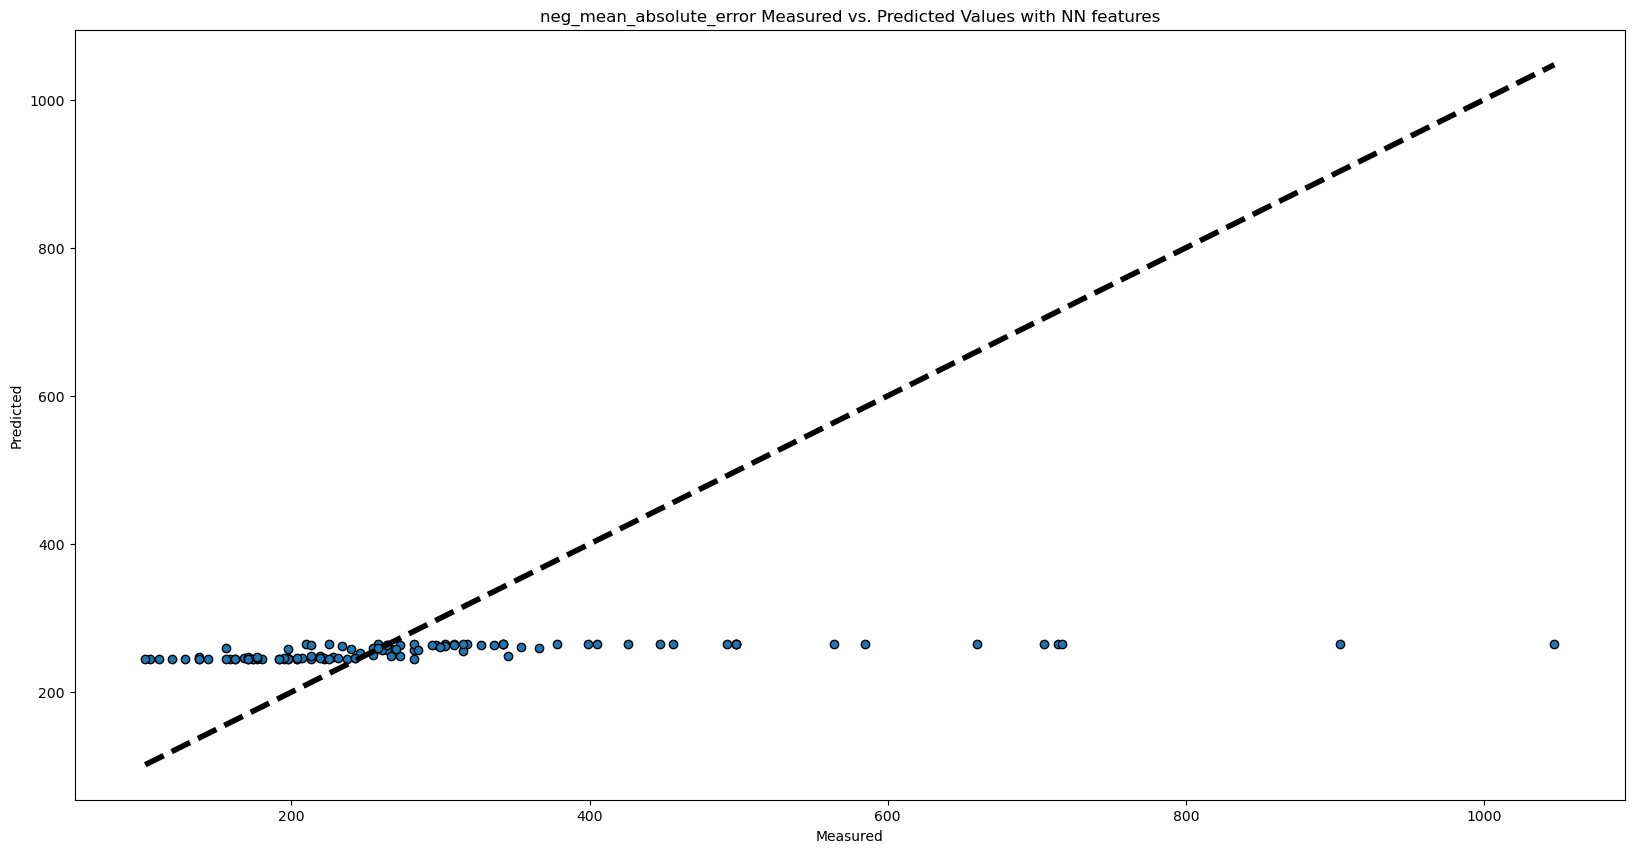

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END colsample_bytree=0.9, gamma=5, learning_rate=0.01, max_depth=10, n_estimators=1, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=5, learning_rate=0.01, max_depth=10, n_estimators=1, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=5, learning_rate=0.01, max_depth=10, n_estimators=1, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=5, learning_rate=0.01, max_depth=10, n_estimators=1, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=5, learning_rate=0.01, max_depth=10, n_estimators=1, reg_alpha=0.5, reg_lambda=1, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=3, n_estimators=81, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=   0.3s
[CV] END colsample_bytre

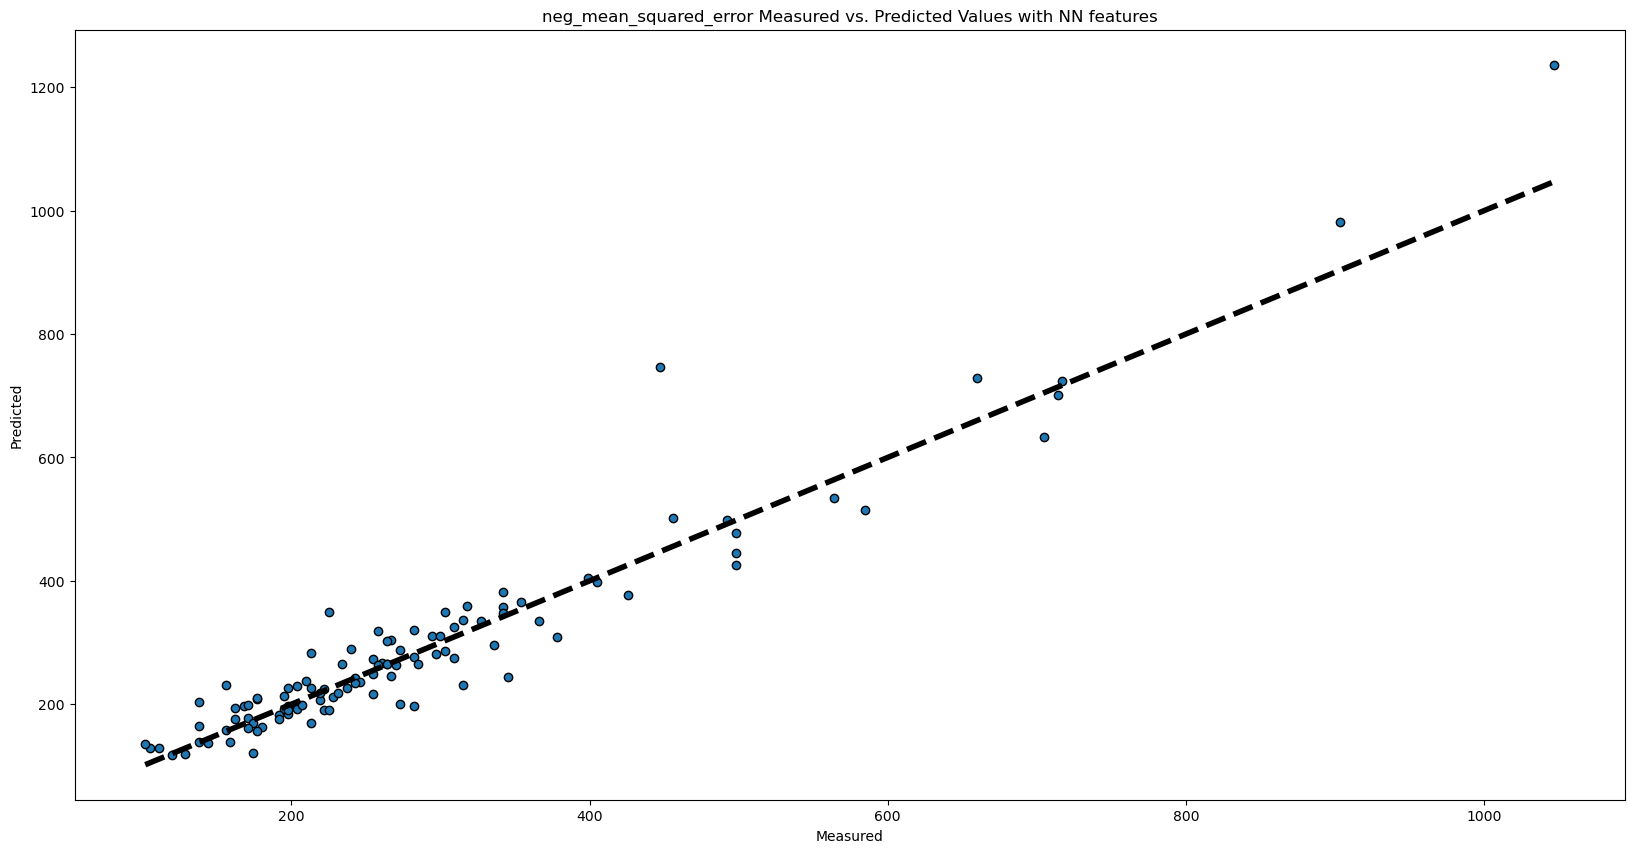

In [25]:
import xgboost
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Model
from IPython.display import clear_output
from datetime import timedelta

def rmsle(y_true, y_pred):

    if np.any(y_pred <= 0):
        return 1e6

    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# Kerätään ensin kaikkien mallien ominaisuusvektorit
X_train_features_list = []
X_test_features_list = []

for model in best_optuna_models:
    feature_extractor = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    X_train_features = feature_extractor.predict(X_train_NN)
    X_test_features = feature_extractor.predict(X_test_NN)
    
    X_train_features_list.append(X_train_features)
    X_test_features_list.append(X_test_features)

# Yhdistetään ominaisuusvektorit
X_train_combined = np.concatenate(X_train_features_list, axis=1)
X_test_combined = np.concatenate(X_test_features_list, axis=1)

X_train_combined = np.concatenate([X_train_combined, X_train], axis=1)   
X_test_combined = np.concatenate([X_test_combined, X_test], axis=1)

virhe_mallit = [xgboost.XGBRegressor(objective='reg:absoluteerror'), xgboost.XGBRegressor(objective='reg:squarederror')]
virhe_nimi = ['neg_mean_absolute_error', 'neg_mean_squared_error']

for idx, malli in enumerate(virhe_mallit):
    time_start = time.time()

    xgb = xgboost.XGBRegressor(objective ='reg:squarederror')
    param_space = {
        'n_estimators': np.arange(1, 500, 20),
        'max_depth': np.arange(2, 11),
        'learning_rate': [0.1, 0.01, 0.001],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'gamma': [0, 1, 5],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [1, 1.5, 2]
    }

    random_search = RandomizedSearchCV(
        estimator=malli,
        param_distributions=param_space,
        cv=5,
        n_jobs=-2,
        n_iter=100,
        verbose=1,
        scoring=rmsle_scorer        
    )

    start_time = time.time()
    random_search.fit(X_train_combined, y_train)
    best_model = random_search.best_estimator_
    end_time = time.time()
    elapsed_time = end_time - start_time

    predictions = best_model.predict(X_test_combined)
    
    time_end = time.time()

    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    rmsle = rmsle_score(y_test, predictions)
    print(f"MAE: {mae}\nMSE: {mse}\nR2: {r2}\nRMSLE: {rmsle}")
    print(f"Time taken {str(timedelta(seconds=(time_end - time_start)))}")
    print(f"Feature shape: {X_train_combined.shape}")

    plt.figure(figsize=(20, 10)) 
    plt.scatter(y_test, predictions, edgecolors=(0, 0, 0))
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel('Measured')  
    plt.ylabel('Predicted') 
    plt.title(f'{virhe_nimi[idx]} Measured vs. Predicted Values with NN features')
    plt.show()




MAE: 30.693111772890443
MSE: 2452.511720151658
 R2: 0.9032080390102667
RMSLE: 0.14697671286359112
Random search took 5.349961042404175 seconds
Feature shape: (972, 100)


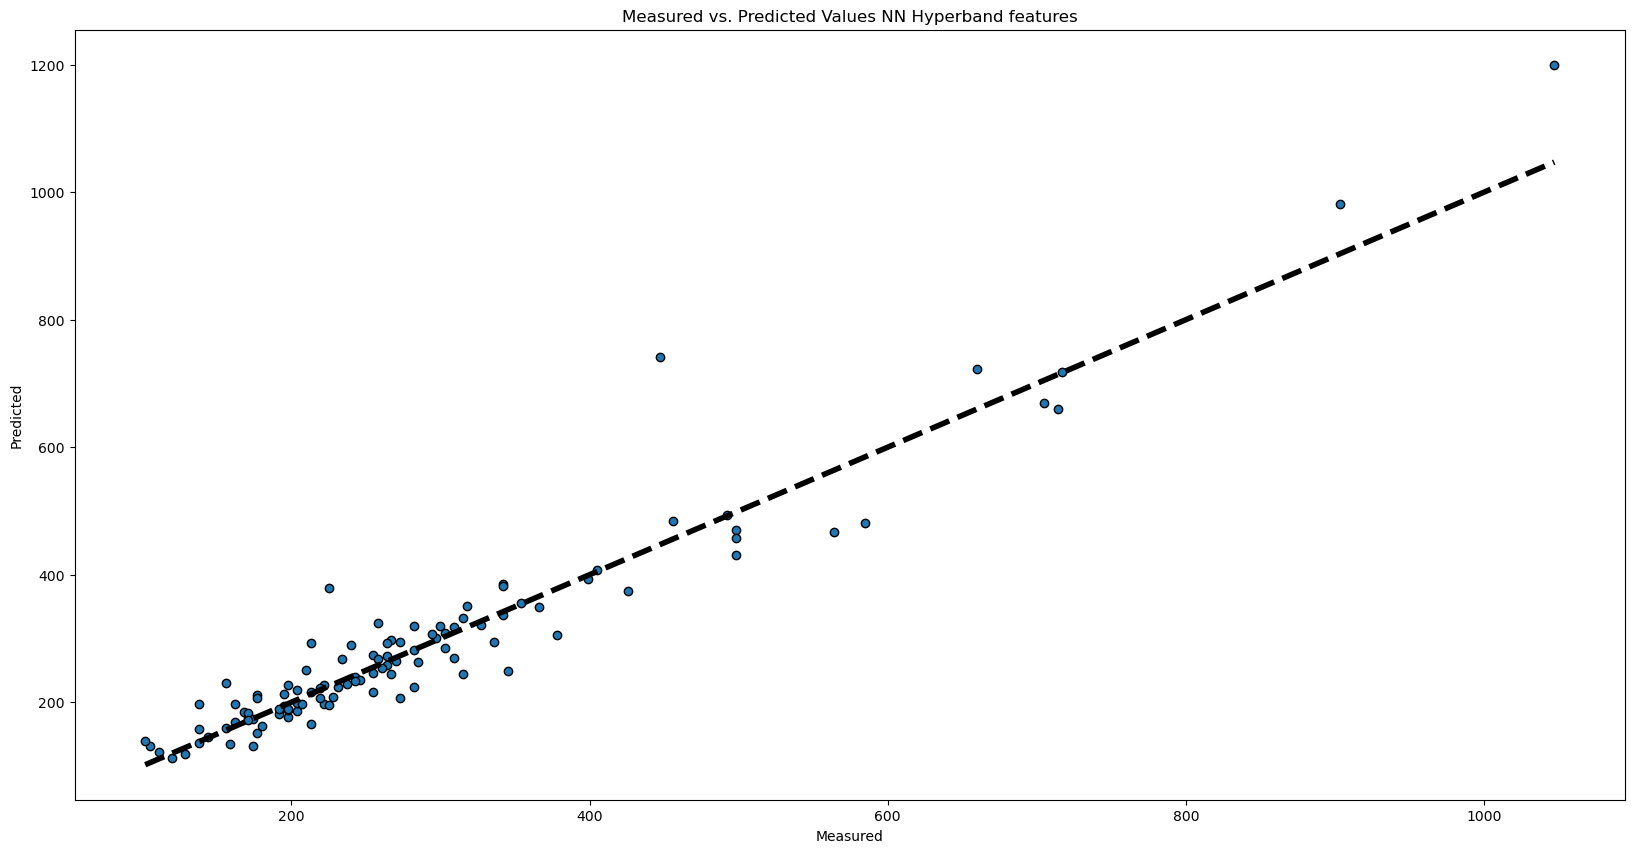

In [24]:
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
rmsle = rmsle_score(y_test, predictions)
print(f"MAE: {mae}\nMSE: {mse}\n R2: {r2}\nRMSLE: {rmsle}")
print(f"Random search took {elapsed_time} seconds")
print(f"Feature shape: {X_train_combined.shape}")

plt.figure(figsize=(20, 10)) 
plt.scatter(y_test, predictions, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Measured')  
plt.ylabel('Predicted') 
plt.title('Measured vs. Predicted Values NN Hyperband features')
plt.show()